# Imports

In [1]:
import requests
import json
import math
import random
import os

import pandas as pd
import numpy as np
from statsmodels.robust.scale import mad
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima
from tensorflow.config import list_physical_devices
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
sns.set_style("white")
# import plotly.graph_objects as go

from IPython.display import display
from tqdm import tqdm

import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 

## Stats functions

In [4]:
def file_stats(df):
    df_first_date = df.iloc[0].datetime
    df_last_date = df.iloc[-1].datetime
    print(f'First date\t{df_first_date}')
    print(f'Last date\t{df_last_date}')
    df_first_date_dt = datetime.strptime(df_first_date,'%Y-%m-%d %H:%M:%S')
    df_last_date_dt = datetime.strptime(df_last_date,'%Y-%m-%d %H:%M:%S')
    print(f'Expected dates\t{df_last_date_dt - df_first_date_dt + timedelta(minutes=15)}')
    print(f'Total dates\t{len(df)/96/14}')

def preds_vs_actual_stats(col_actual, col_preds):
    mean_actual = col_actual.mean()
    median_actual = col_actual.median()
    mode_actual = col_actual.mode()[0] if not col_actual.mode().empty else np.nan
    stddev_actual = col_actual.std()
    
    mean_preds = col_preds.mean()
    median_preds = col_preds.median()
    mode_preds = col_preds.mode()[0] if not col_preds.mode().empty else np.nan
    stddev_preds = col_preds.std()
    
    error = col_preds - col_actual
    error_pc = np.divide(error, col_actual, out=np.zeros_like(error), where=col_actual != 0) * 100

    positive_errors = error[error > 0].count()
    negative_errors = error[error < 0].count()
    mean_error = error.mean()
    mae = mean_absolute_error(col_actual, col_preds)
    mse = mean_squared_error(col_actual, col_preds)
    rmse = np.sqrt(mse)
    median_error = error.median()
    medae = median_absolute_error(col_actual, col_preds)
    mode_error = error.mode()[0] if not error.mode().empty else np.nan
    stddev_error = error.std()
    min_error = error.min()
    max_error = error.max()

    mean_error_pc = error_pc.mean()
    mape = np.mean(np.divide(np.abs(error), col_actual, out=np.zeros_like(error), where=col_actual != 0) * 100)
    smape = np.mean(2 * np.abs(col_actual - col_preds) / (np.abs(col_actual) + np.abs(col_preds))) * 100
    min_error_pc = error_pc.min()
    max_error_pc = error_pc.max()
    
    mbd = np.mean(error) / mean_actual * 100 if mean_actual != 0 else np.nan
    
    try:
        r2 = r2_score(col_actual, col_preds)
        corr = np.corrcoef(col_actual, col_preds)[0, 1]
    except ValueError:
        r2, corr = np.nan, np.nan  # Handle cases with insufficient variation
    
    theils_u = np.sqrt(np.mean((col_preds - col_actual)**2)) / np.sqrt(np.mean((col_actual.shift(-1) - col_actual)**2)) if not col_actual.shift(-1).isna().all() else np.nan
    
    return (mean_actual, mean_preds, median_actual, median_preds, mode_actual, mode_preds, stddev_actual, stddev_preds,
            positive_errors, negative_errors, mean_error, mae, mse, rmse,
            median_error, medae, mode_error, stddev_error, min_error, max_error,
            mean_error_pc, mape, smape, min_error_pc, max_error_pc,
            mbd, r2, corr, theils_u)

stats_column_order = [
        "Mean (Actual)", "Mean (Predicted)", "Median (Actual)", "Median (Predicted)", "Mode (Actual)", "Mode (Predicted)", "Std Dev (Actual)", "Std Dev (Predicted)",
        "Positive Errors", "Negative Errors", "Mean Error", "MAE", "MSE", "RMSE",
        "Median Error", "MedAE", "Mode Error", "Std Dev Error", "Min Error", "Max Error",
        "Mean Error (%)", "MAPE", "SMAPE", "Min Error (%)", "Max Error (%)", 
        "Mean Bias Deviation (%)", "R² Score", "Correlation Coefficient", "Theil's U"
    ]

def preds_vs_actual_stats_df(col_actual, col_preds):
    stats = preds_vs_actual_stats(col_actual, col_preds)
    metric_names = stats_column_order
    stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
    df_metrics = pd.DataFrame({"Metric": metric_names, "Value": stats_formatted})
    return df_metrics

# Data preprocessing

## Importing the data

### From a file

In [5]:
# raw_data = pd.read_csv('ods032.csv', delimiter=';')
raw_data = pd.read_csv('ods032-api.csv')

In [6]:
df = raw_data.copy()
file_stats(df)

First date	2018-10-01 00:00:00
Last date	2024-10-27 23:45:00
Expected dates	2219 days, 0:00:00
Total dates	2219.0


### From the API

#### Full run

In [6]:
df = pd.DataFrame()
start_date = datetime(2018, 10, 1) # first day of data
end_date = datetime(2018, 10, 1) # yesterday, to avoid partial days
date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
max_iterations = len(date_list) * len(regions)

with tqdm(total=max_iterations, desc='Fetching data') as pbar:
    for region in regions:
        for date in date_list:
            url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
            r = requests.get(url)
            if r.status_code == 200:
                temp_df = pd.DataFrame(r.json()['results'])
                df = pd.concat([df, temp_df], ignore_index=True)
            pbar.update(1)

df.datetime = pd.to_datetime(df.datetime, utc=True)
df.datetime = df.datetime.dt.tz_localize(None)
df.set_index("datetime").sort_index().reset_index().to_csv('ods032-api.csv', index=False)

#### Update

In [ ]:
api_data = pd.read_csv('ods032-api.csv')
file_stats(apidata)
api_data_backup = api_data.copy()

In [ ]:
# set start date to first day after current dataset

new_start_date = datetime.strptime(api_data.iloc[-1].datetime,'%Y-%m-%d %H:%M:%S') + timedelta(days=1)
new_start_year = new_start_date.year
new_start_month = new_start_date.month
new_start_day = new_start_date.day

# set number of days to get

# new_days = 364
# new_end_date = new_start_date + timedelta(days=new_days-2)
# new_end_year = new_end_date.year
# new_end_month = new_end_date.month
# new_end_day = new_end_date.day

# or set fixed end dat

new_end_year = 2024
new_end_month = 10
new_end_day = 28

df_new = pd.DataFrame()

start_date = datetime(new_start_year, new_start_month, new_start_day)
end_date = datetime(new_end_year, new_end_month, new_end_day) # inclusive
date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
max_iterations = len(date_list) * len(regions)

print(f'Days: {len(date_list)}, from {date_list[0]} to {date_list[-1]}')

with tqdm(total=max_iterations, desc='Fetching data') as pbar:
    for region in regions:
        for date in date_list:
            url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
            r = requests.get(url)
            if r.status_code == 200:
                temp_df = pd.DataFrame(r.json()['results'])
                df_new = pd.concat([df_new, temp_df], ignore_index=True)
            pbar.update(1)

df_new.datetime = pd.to_datetime(df_new.datetime, utc=True)
df_new.datetime = df_new.datetime.dt.tz_localize(None)
df_new = df_new.set_index("datetime").sort_index().reset_index()
df_new.to_csv('ods032-api.csv', mode='a', header=False, index=False)
df = pd.concat([api_data, df_new], ignore_index=True)
df

## Processing

In [5]:
df.duplicated().sum()
# df.drop_duplicates()

0

In [7]:
df = df.rename(columns={'Datetime':'datetime',
                        'Region':'region',
                        'Measured & Upscaled':'measured',
                        'Most recent forecast':'forecast_recent',
                        'Week-ahead forecast':'forecast_week',
                        'Day-ahead 6PM forecast':'forecast_day',
                        'mostrecentforecast':'forecast_recent',
                        'dayaheadforecast':'forecast_day',
                        'weekaheadforecast':'forecast_week'})
df.datetime = pd.to_datetime(df.datetime, utc=True)
df.set_index("datetime", inplace=True)
df = df.sort_index()
df = df.ffill().bfill()

df_fullyears = df['2019-01-01':'2023-12-31'].copy()
df_be = df[df.region == 'Belgium'].drop(['region'], axis=1).copy()
df_be_fullyears = df_be['2019-01-01':'2023-12-31'].copy()

# Data exploration 

## Describe

In [7]:
pd.options.display.float_format = '{:,.2f}'.format
display(df.describe())
pd.options.display.float_format = None

measured  forecast_recent  forecast_day  forecast_week
count 2,982,336.00     2,982,336.00  2,982,336.00   2,982,336.00
mean        137.48           136.36        136.88         129.52
std         430.63           421.82        424.47         393.90
min           0.00             0.00          0.00           0.00
25%           0.00             0.00          0.00           0.00
50%           0.14             0.50          0.51           0.42
75%          75.69            77.13         77.80          78.17
max       7,526.47         7,055.24      7,280.85       6,512.31

## Plots

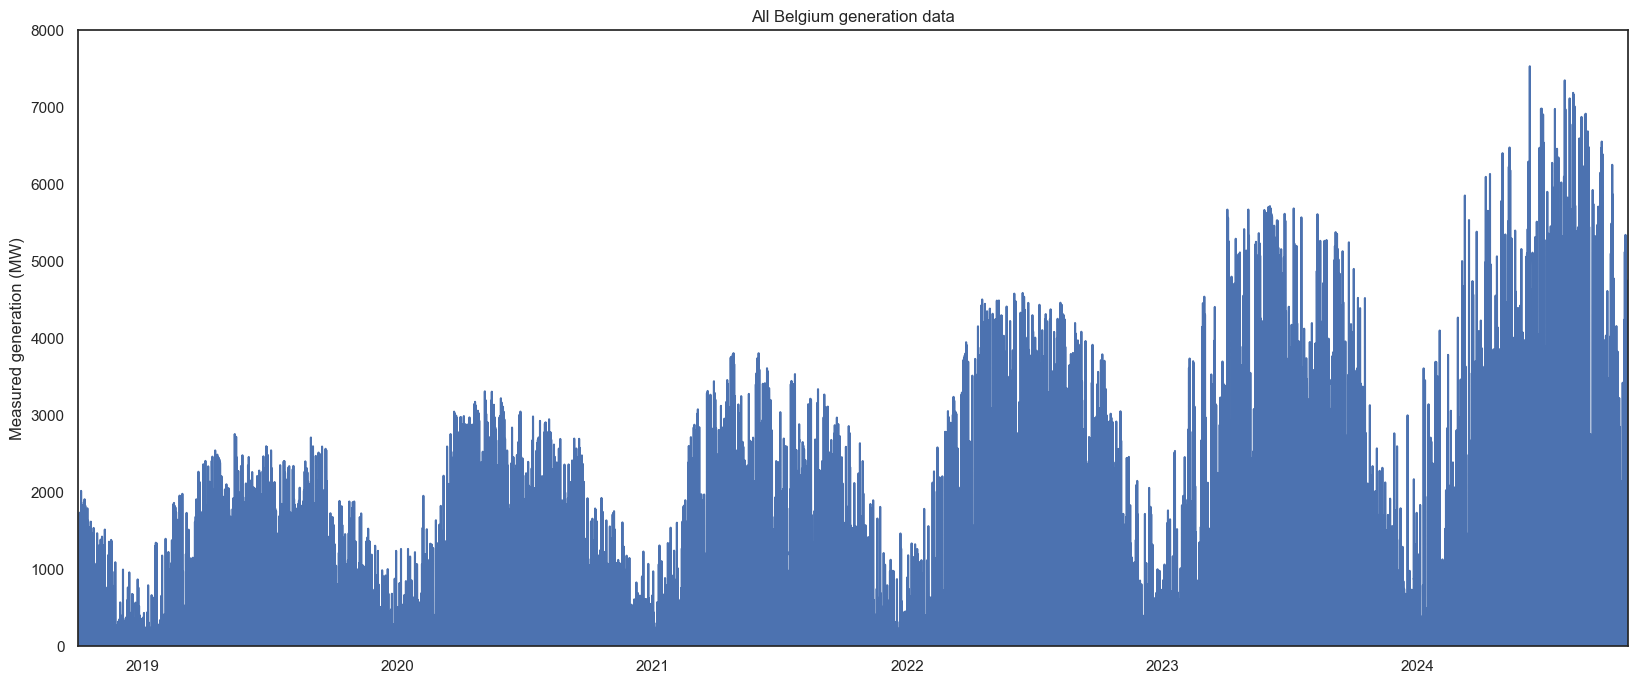

In [8]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be.measured)
plt.ylabel('Measured generation (MW)')
plt.ylim(0,8000)
plt.xlabel('')
plt.xlim(df_be.iloc[0].name,df_be.iloc[-1].name)
plt.title('All Belgium generation data')
plt.show()

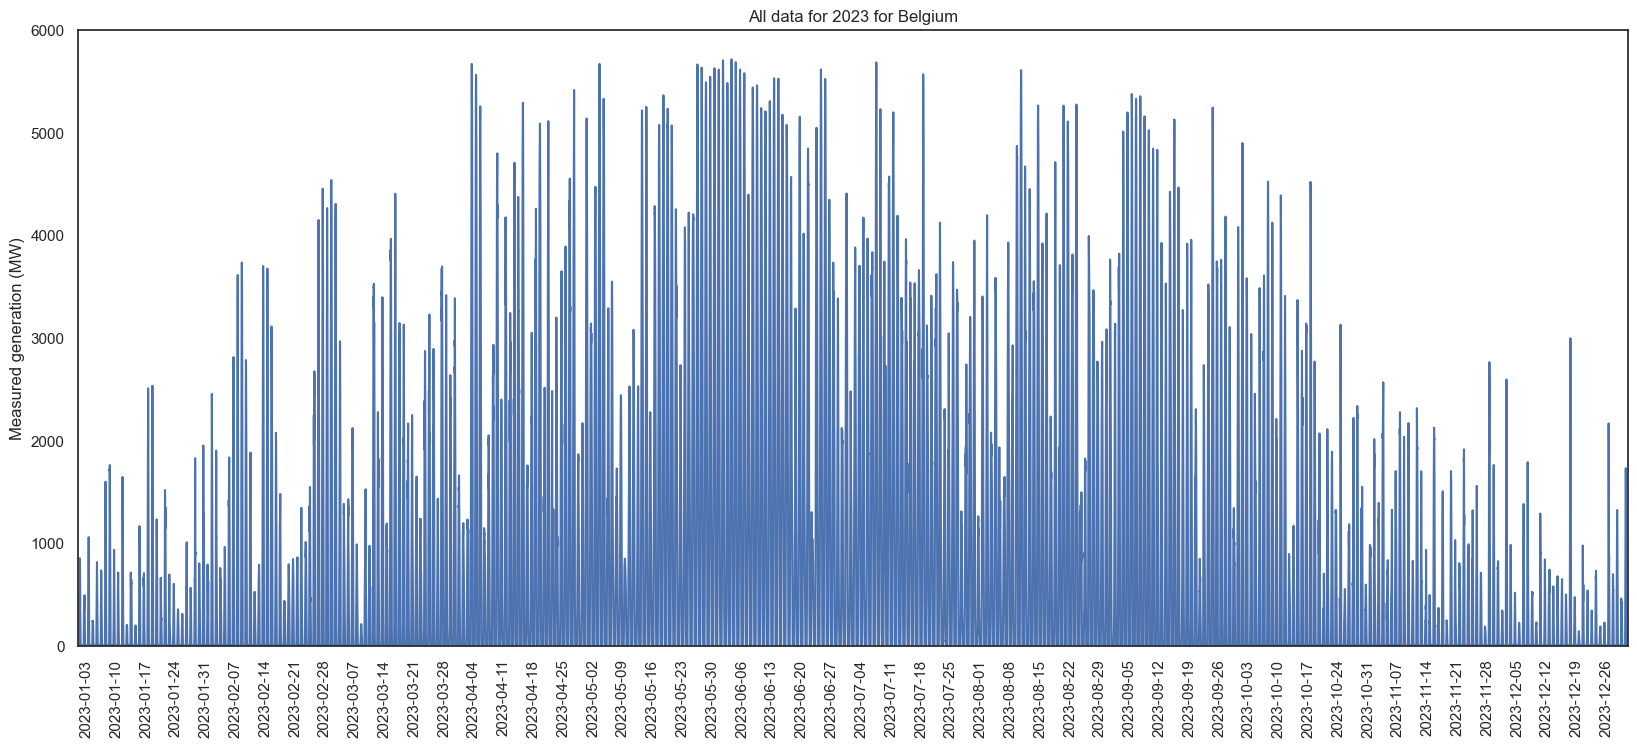

In [159]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured)
plt.ylabel('Measured generation (MW)')
plt.ylim(0,6000)
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title('All data for 2023 for Belgium')
plt.show()

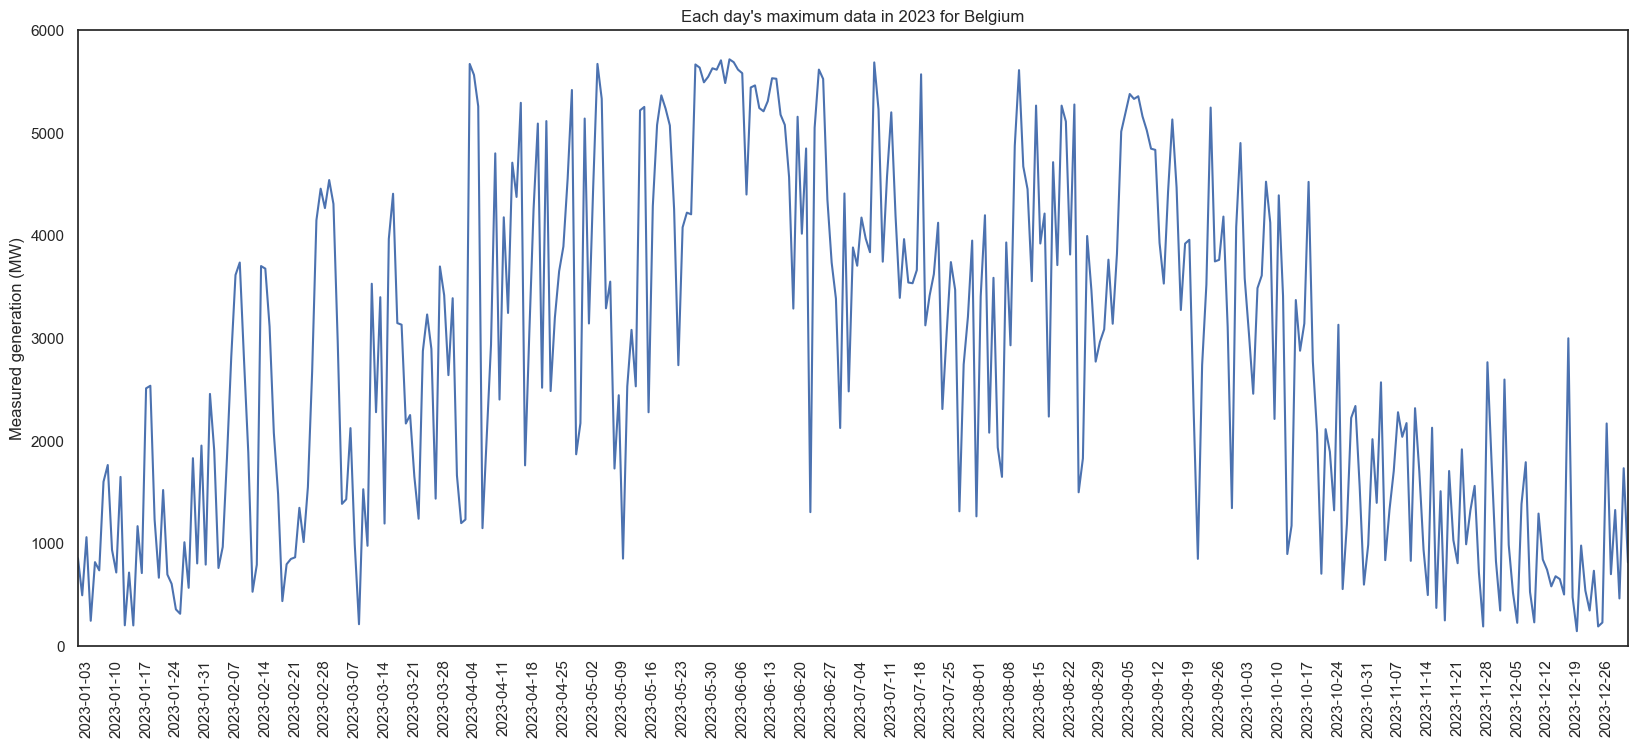

In [160]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured.resample('D').max())
plt.ylabel('Measured generation (MW)')
plt.ylim(0,6000)
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title("Each day's maximum data in 2023 for Belgium")
plt.show()

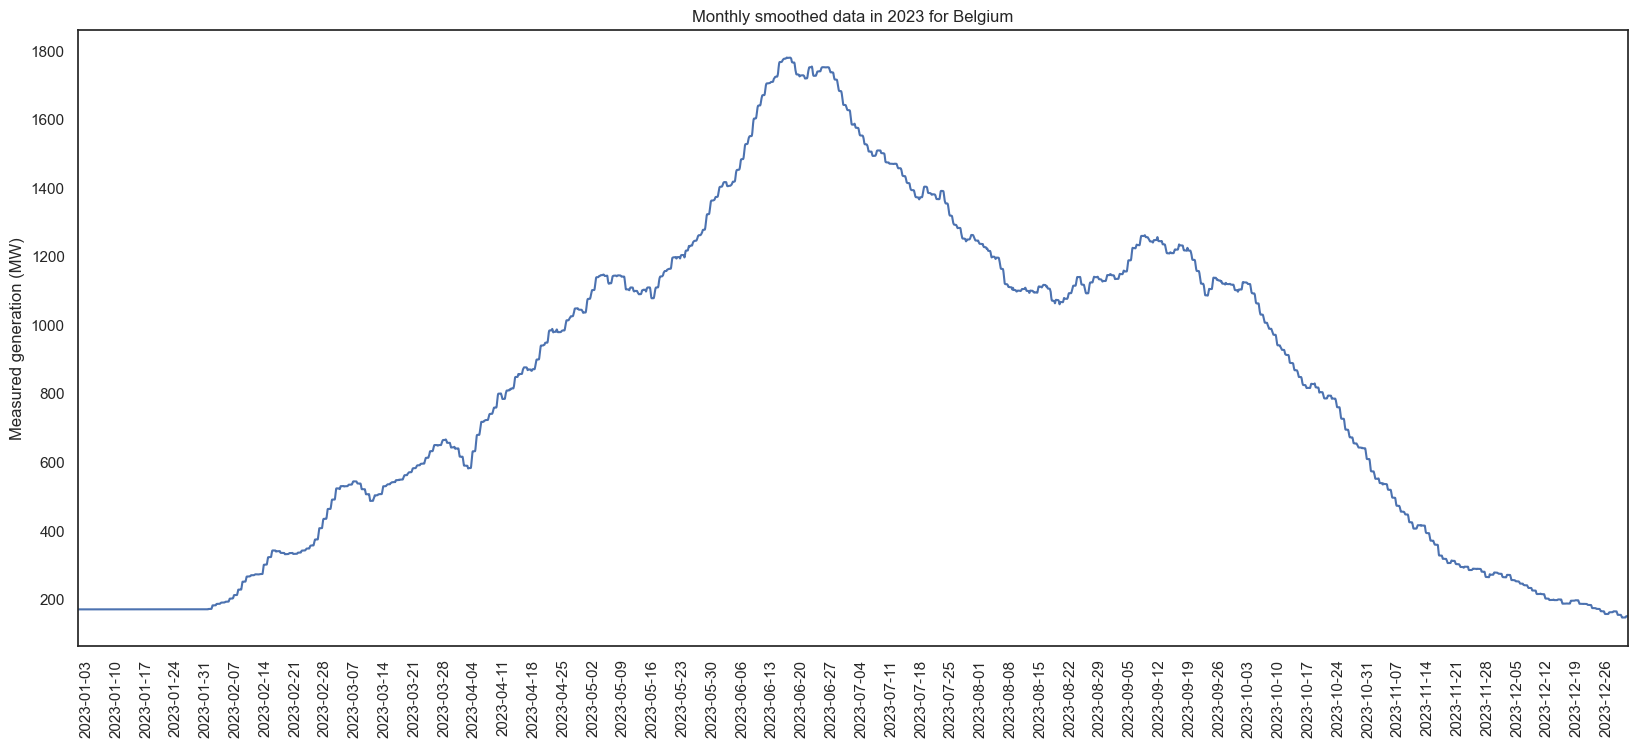

In [19]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured.rolling(window=96*30).mean().bfill())
plt.ylabel('Measured generation (MW)')
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title("Monthly smoothed data in 2023 for Belgium")
plt.show()

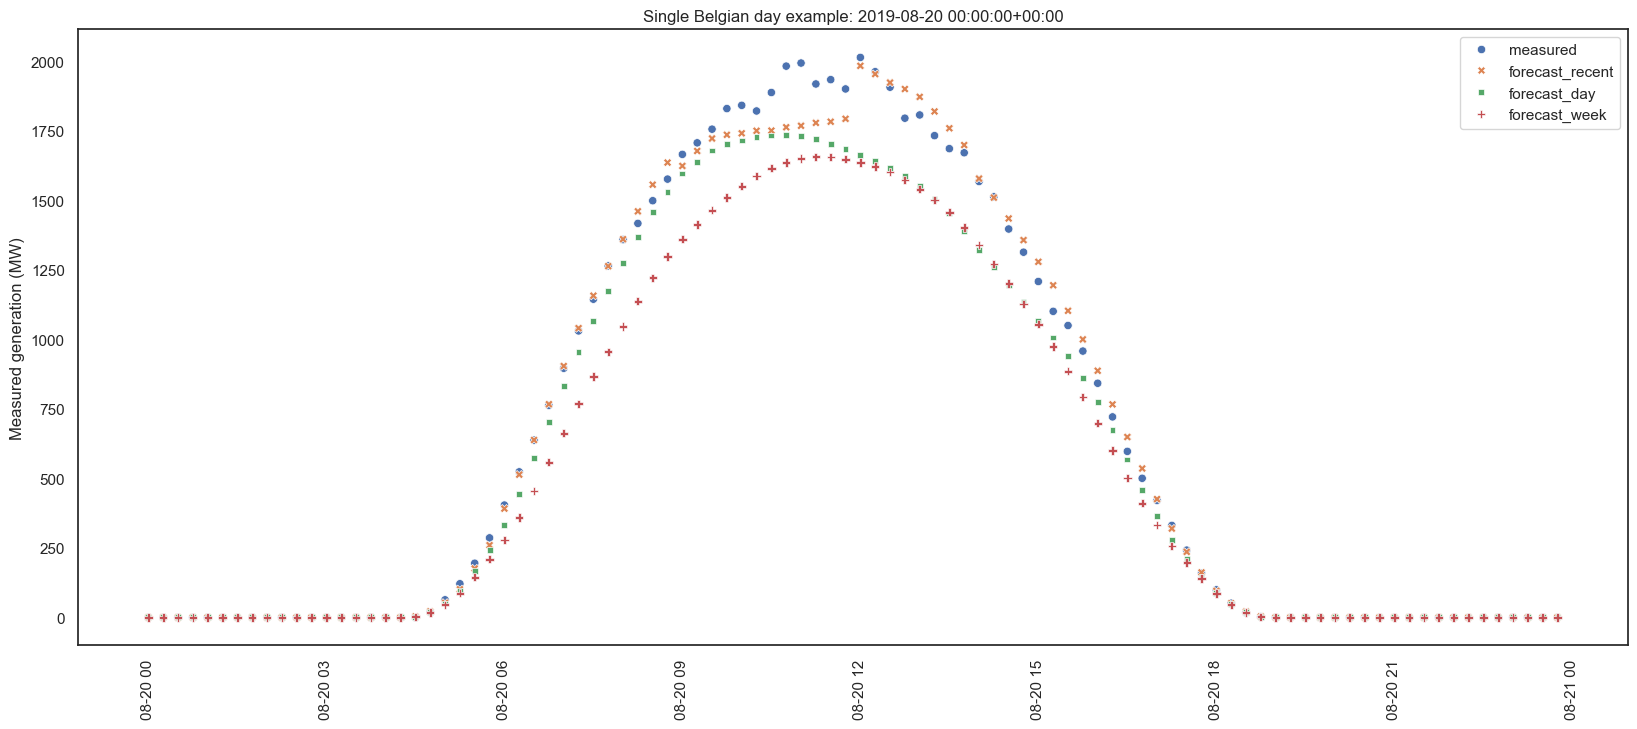

In [ ]:
plt.figure(figsize=(20,8))
random_date = random.choice(df_be.index.normalize().unique())
sns.scatterplot(df_be[['measured','forecast_recent','forecast_day','forecast_week']][df_be.index.normalize() == random_date])
plt.ylabel('Measured generation (MW)')
plt.xlabel('')
plt.xticks(rotation=90)
plt.title(f'Single Belgian day example: {random_date}')
plt.show()

## Grouped by timeframe

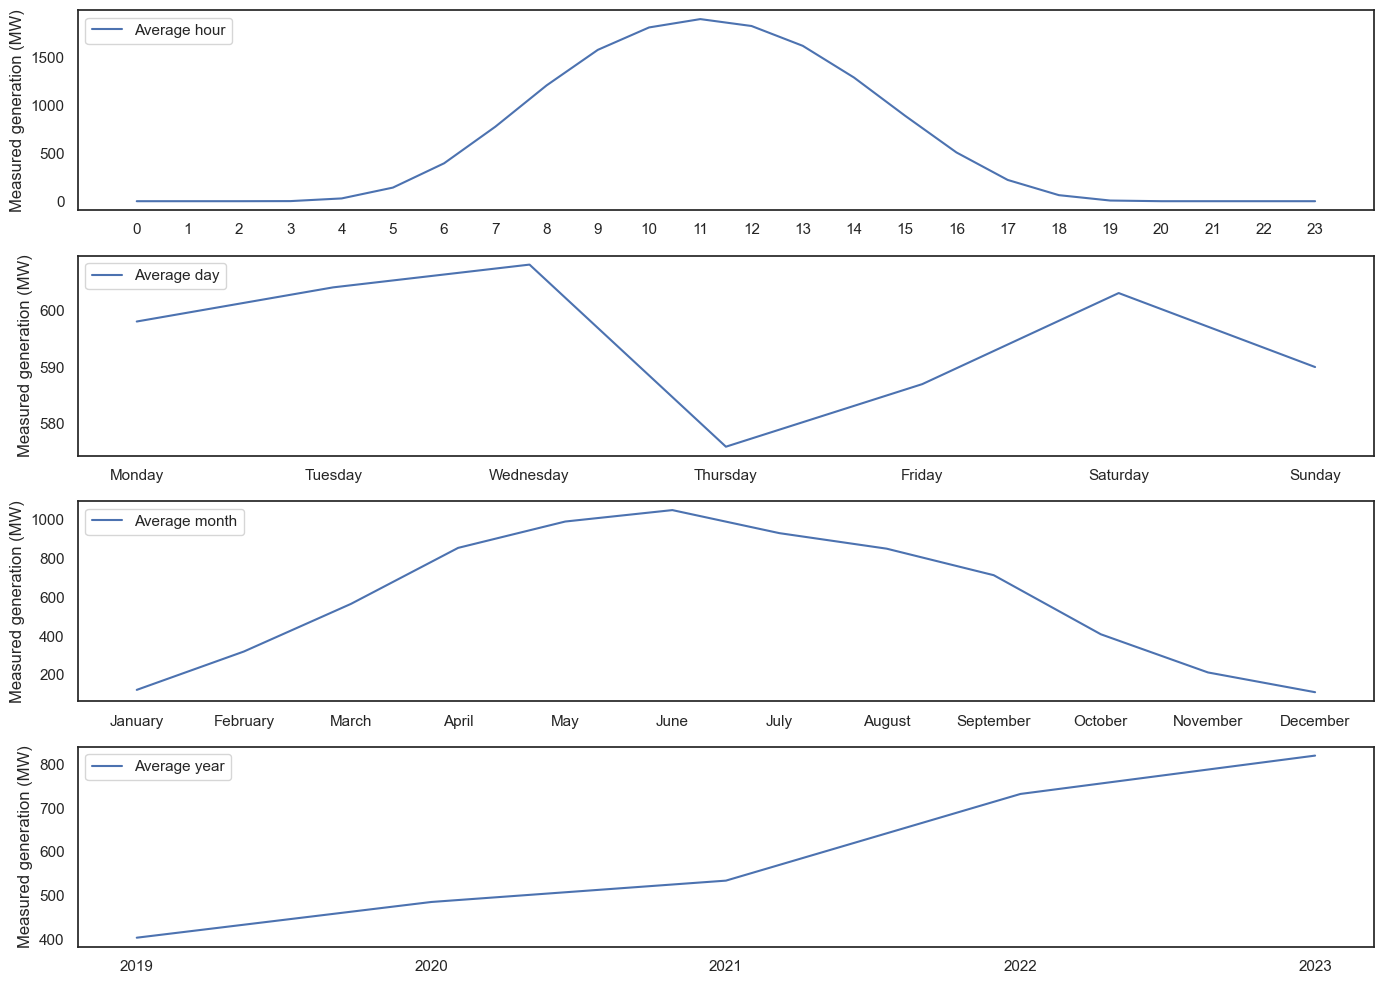

In [9]:
df_timeframe = df_be_fullyears.copy()
df_timeframe['hour'] = df_be_fullyears.index.hour
df_timeframe['day_of_week'] = df_be_fullyears.index.dayofweek
df_timeframe['month'] = df_be_fullyears.index.month
df_timeframe['year'] = df_be_fullyears.index.year

df_timeframe_hour = df_timeframe.groupby('hour').mean()[['measured']].round()
df_timeframe_day_of_week = df_timeframe.groupby('day_of_week').mean()[['measured']].round()
df_timeframe_day_of_week.index = pd.Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_timeframe_month = df_timeframe.groupby('month').mean()[['measured']].round()
df_timeframe_month.index = pd.Index(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
df_timeframe_year = df_timeframe.groupby('year').mean()[['measured']].round()

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df_timeframe_hour, label='Average hour')
plt.ylabel('Measured generation (MW)')
plt.xticks(np.arange(min(df_timeframe_hour.index), max(df_timeframe_hour.index) + 1, 1))
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(df_timeframe_day_of_week, label='Average day')
plt.ylabel('Measured generation (MW)')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(df_timeframe_month, label='Average month')
plt.ylabel('Measured generation (MW)')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(df_timeframe_year, label='Average year')
plt.ylabel('Measured generation (MW)')
plt.xticks(np.arange(min(df_timeframe_year.index), max(df_timeframe_year.index) + 1, 1))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Variation statistics

In [10]:
cv = df_be_fullyears.measured.std() / df_be_fullyears.measured.mean()
print(f"Coefficient of Variation\t{cv:.3f}")
hourly_variation = df_be_fullyears.measured.resample('h').std()
print(f"Average Hourly Variation\t{hourly_variation.mean():.3f}")
daily_variation = df_be_fullyears.measured.resample('D').std()
print(f"Average Daily Variation\t\t{daily_variation.mean():.3f}")
monthly_variation = df_be_fullyears.measured.resample('ME').std()
print(f"Average Monthly Variation\t{monthly_variation.mean():.3f}")
iqr = df_be_fullyears.measured.quantile(0.75) - df_be_fullyears.measured.quantile(0.25)
print(f"Interquartile Range (IQR)\t{iqr:.3f}")

Coefficient of Variation	1.672
Average Hourly Variation	57.516
Average Daily Variation		737.438
Average Monthly Variation	814.156
Interquartile Range (IQR)	851.291


## STL decomposition

In [169]:
df_be_stl = df_be_fullyears.measured.copy()
df_be_stl = df_be_stl.resample('h').mean().asfreq('h')

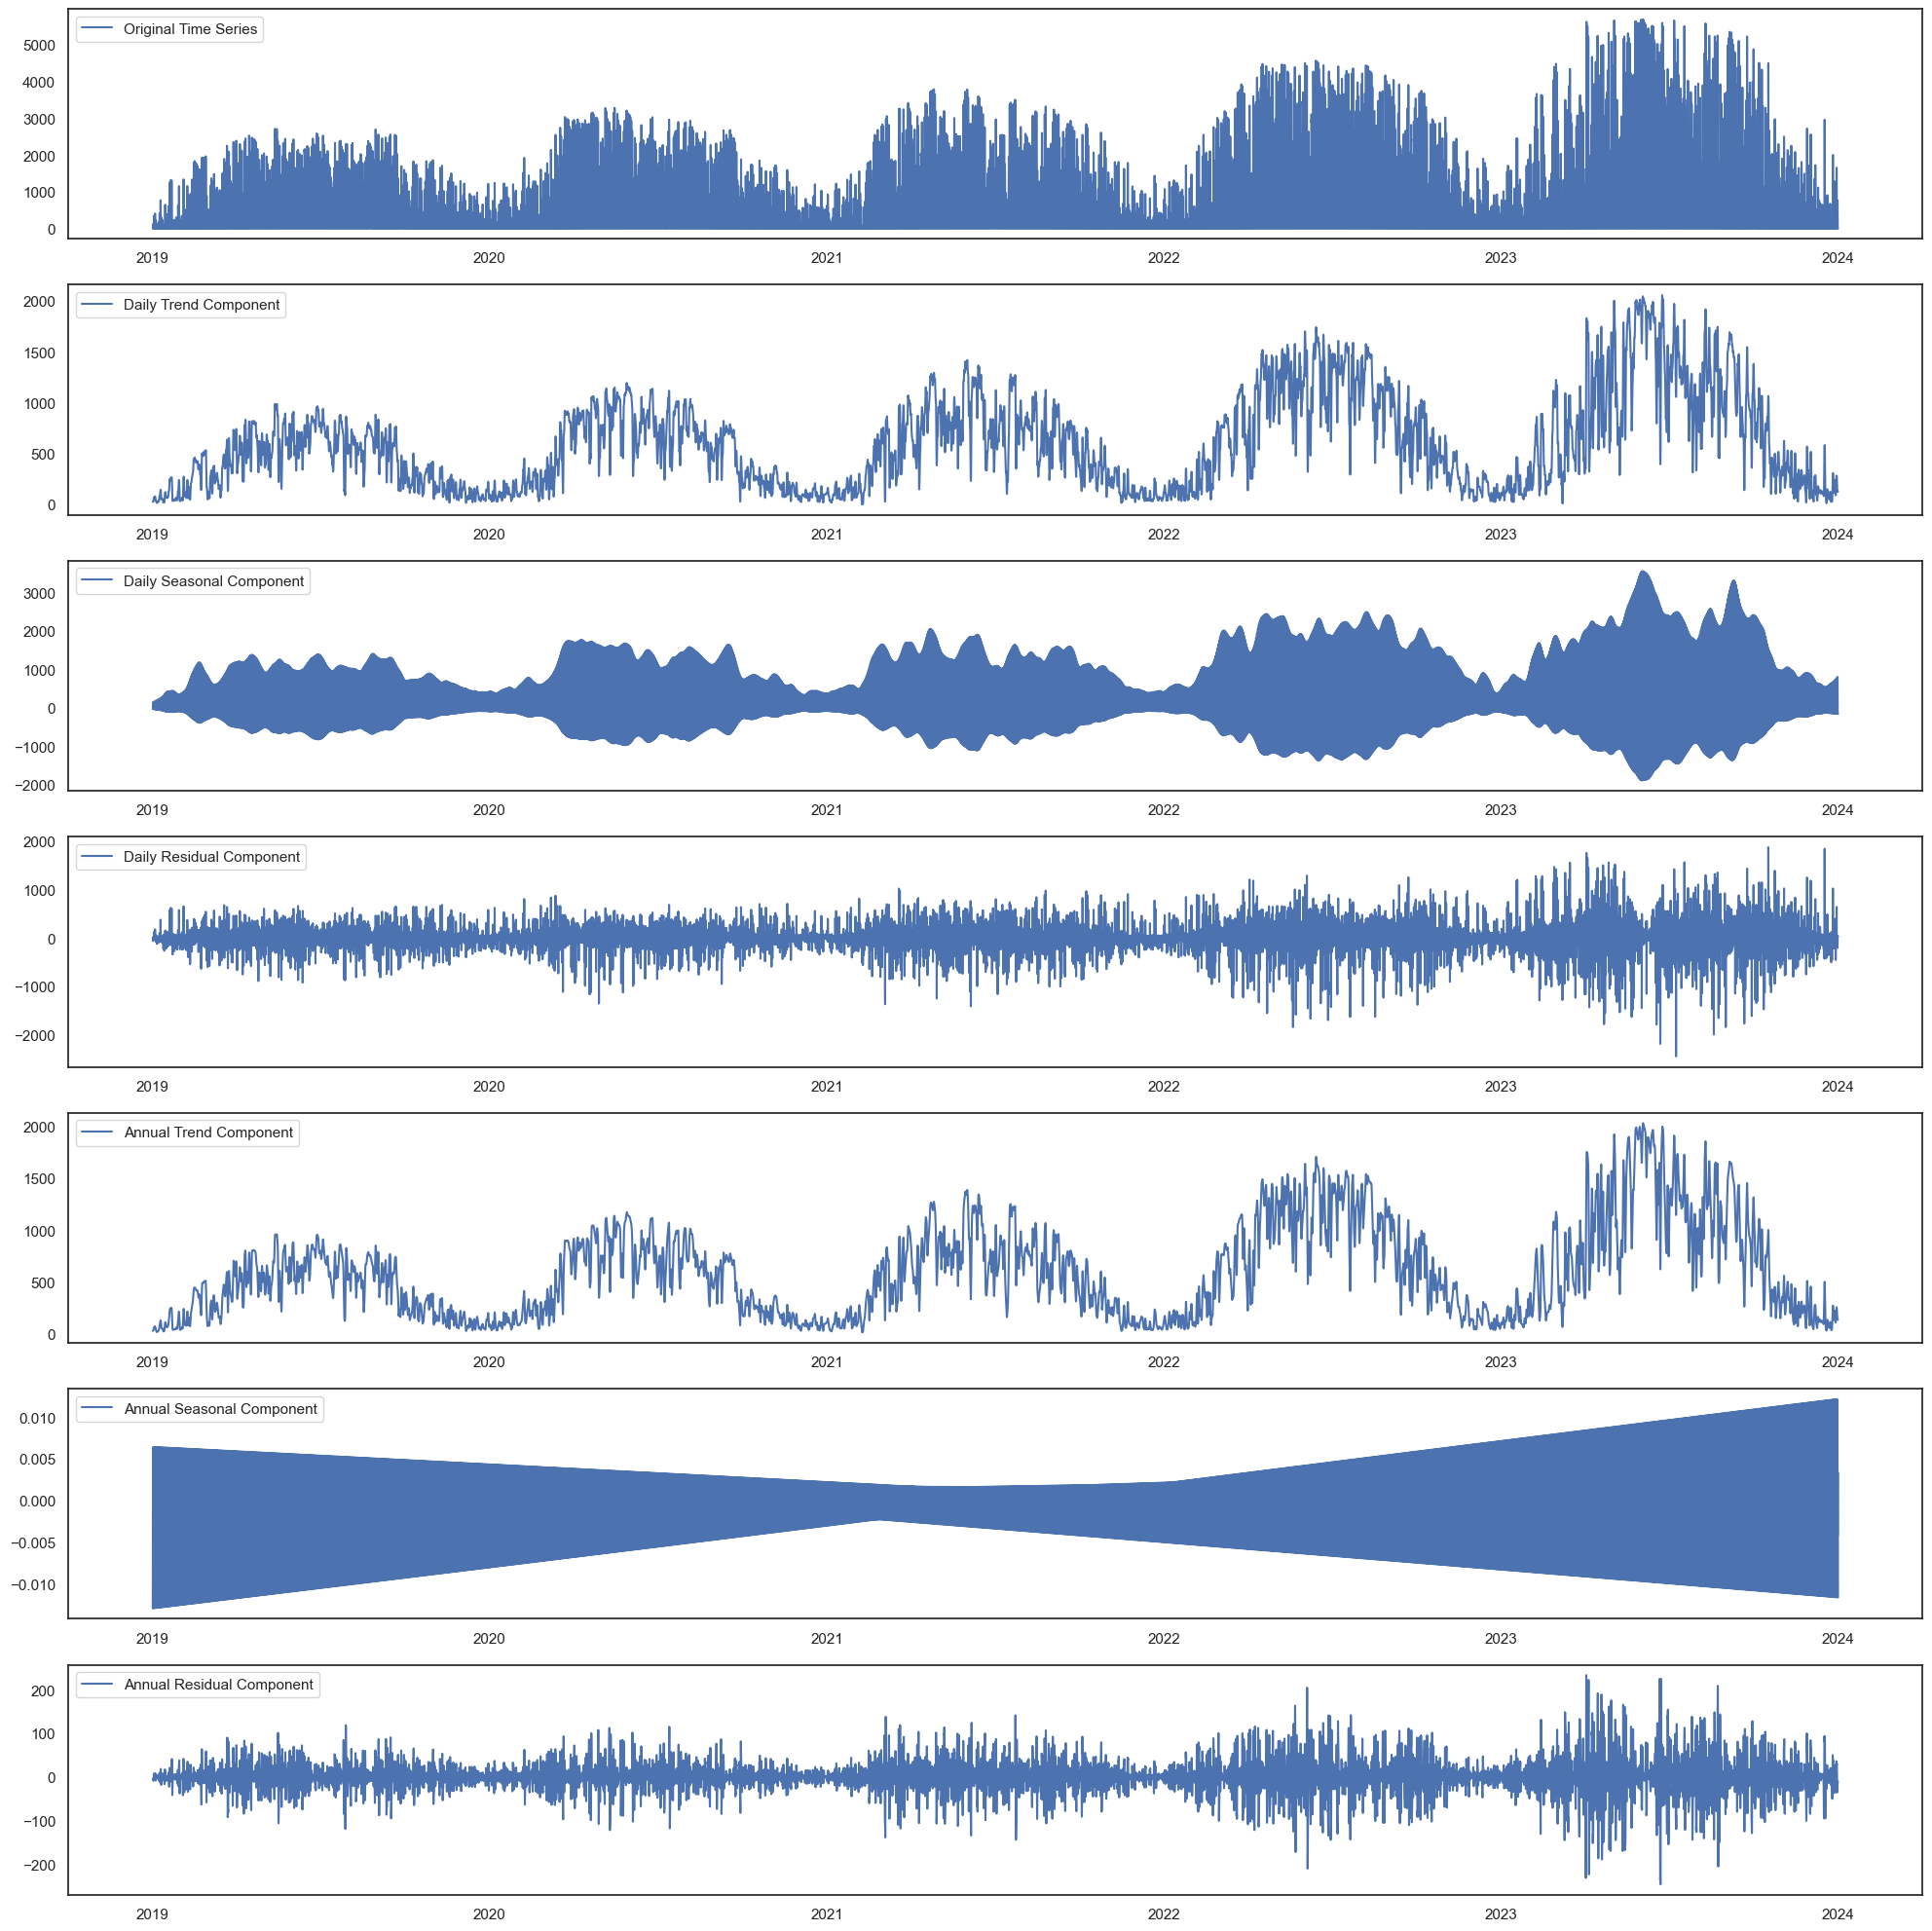

In [188]:
stl_daily = STL(df_be_stl, seasonal=23) # ~24hrs, but needs to be odd - 23 was better than 25
result_daily = stl_daily.fit()

stl_annual = STL(result_daily.trend, seasonal=8759) # £8760hrs / year
result_annual = stl_annual.fit()

daily_trend = result_daily.trend
daily_seasonal = result_daily.seasonal
daily_residual = result_daily.resid

annual_trend = result_annual.trend
annual_seasonal = result_annual.seasonal
annual_residual = result_annual.resid

plt.figure(figsize=(20, 20))
plt.subplot(711)
plt.plot(df_be_stl, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(712)
plt.plot(daily_trend, label='Daily Trend Component')
plt.legend(loc='upper left')
plt.subplot(713)
plt.plot(daily_seasonal, label='Daily Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(714)
plt.plot(daily_residual, label='Daily Residual Component')
plt.legend(loc='upper left')
plt.subplot(715)
plt.plot(annual_trend, label='Annual Trend Component')
plt.legend(loc='upper left')
plt.subplot(716)
plt.plot(annual_seasonal, label='Annual Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(717)
plt.plot(annual_residual, label='Annual Residual Component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

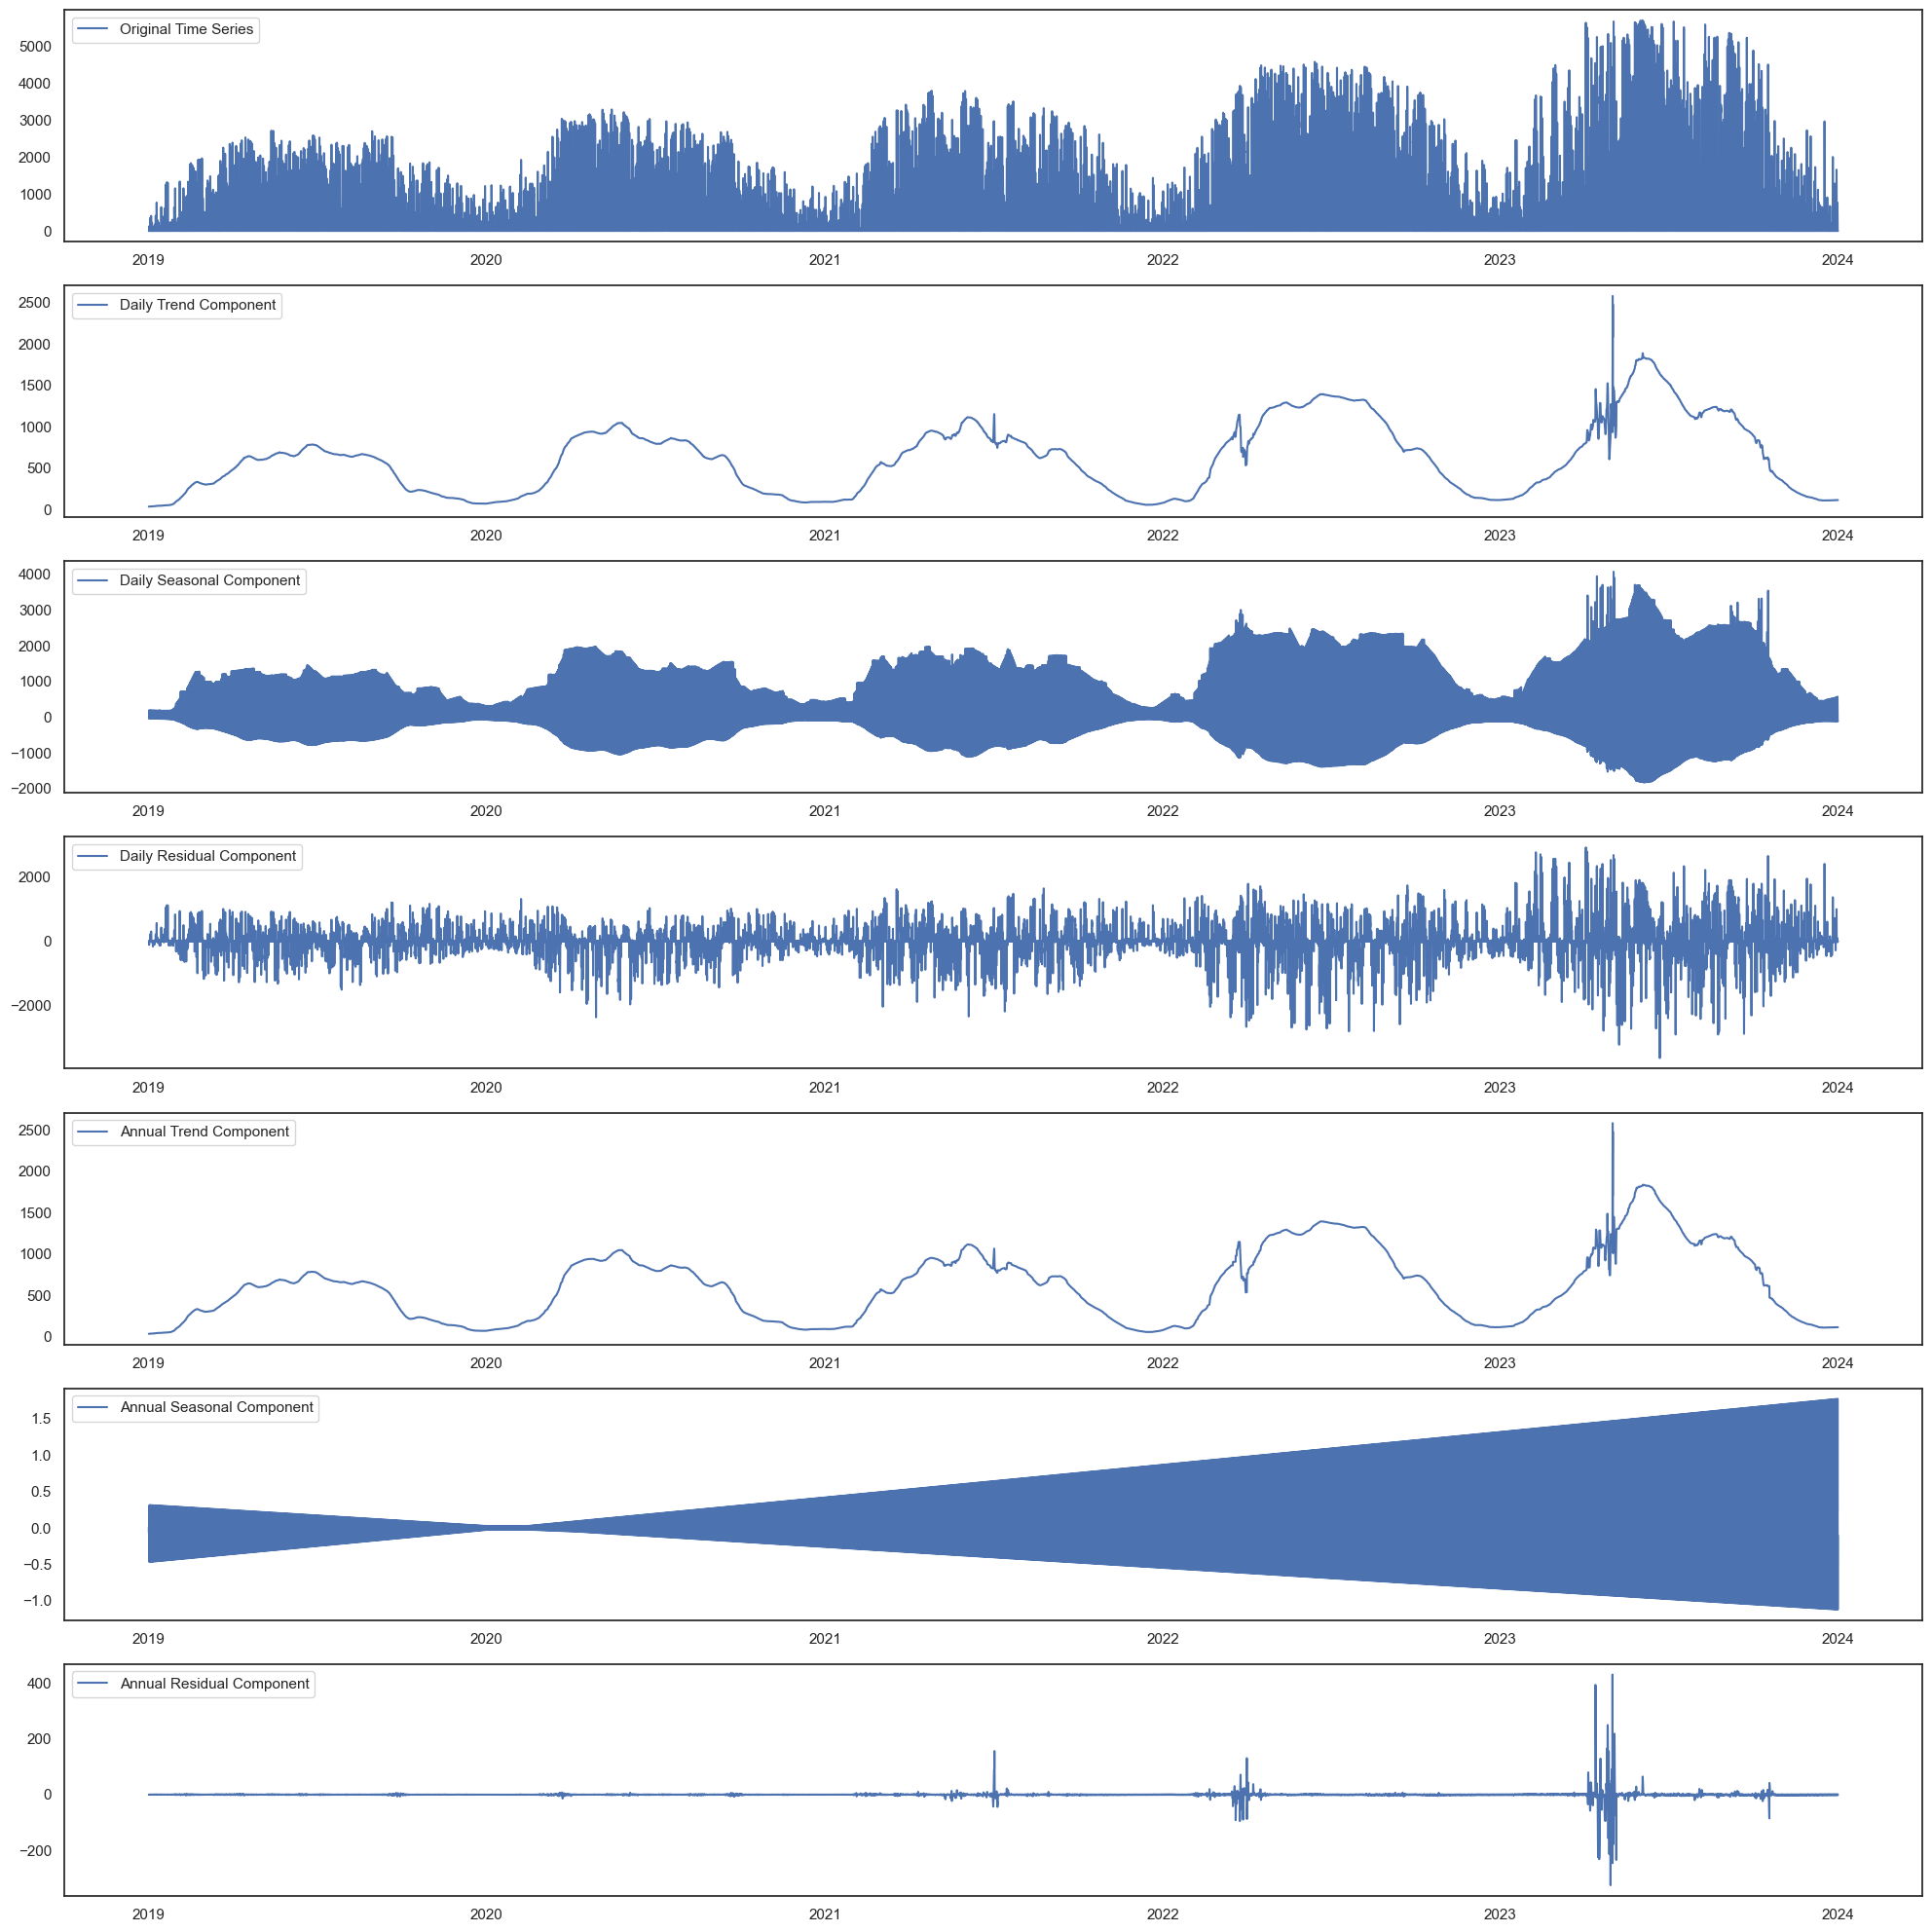

In [190]:
stl_daily = STL(df_be_stl, seasonal=23, robust=True) # ~24hrs, but needs to be odd - 23 was better than 25
result_daily = stl_daily.fit()

stl_annual = STL(result_daily.trend, seasonal=8759, robust=True) # £8760hrs / year
result_annual = stl_annual.fit()

daily_trend = result_daily.trend
daily_seasonal = result_daily.seasonal
daily_residual = result_daily.resid

annual_trend = result_annual.trend
annual_seasonal = result_annual.seasonal
annual_residual = result_annual.resid

plt.figure(figsize=(20, 20))
plt.subplot(711)
plt.plot(df_be_stl, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(712)
plt.plot(daily_trend, label='Daily Trend Component')
plt.legend(loc='upper left')
plt.subplot(713)
plt.plot(daily_seasonal, label='Daily Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(714)
plt.plot(daily_residual, label='Daily Residual Component')
plt.legend(loc='upper left')
plt.subplot(715)
plt.plot(annual_trend, label='Annual Trend Component')
plt.legend(loc='upper left')
plt.subplot(716)
plt.plot(annual_seasonal, label='Annual Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(717)
plt.plot(annual_residual, label='Annual Residual Component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Visualised distributions

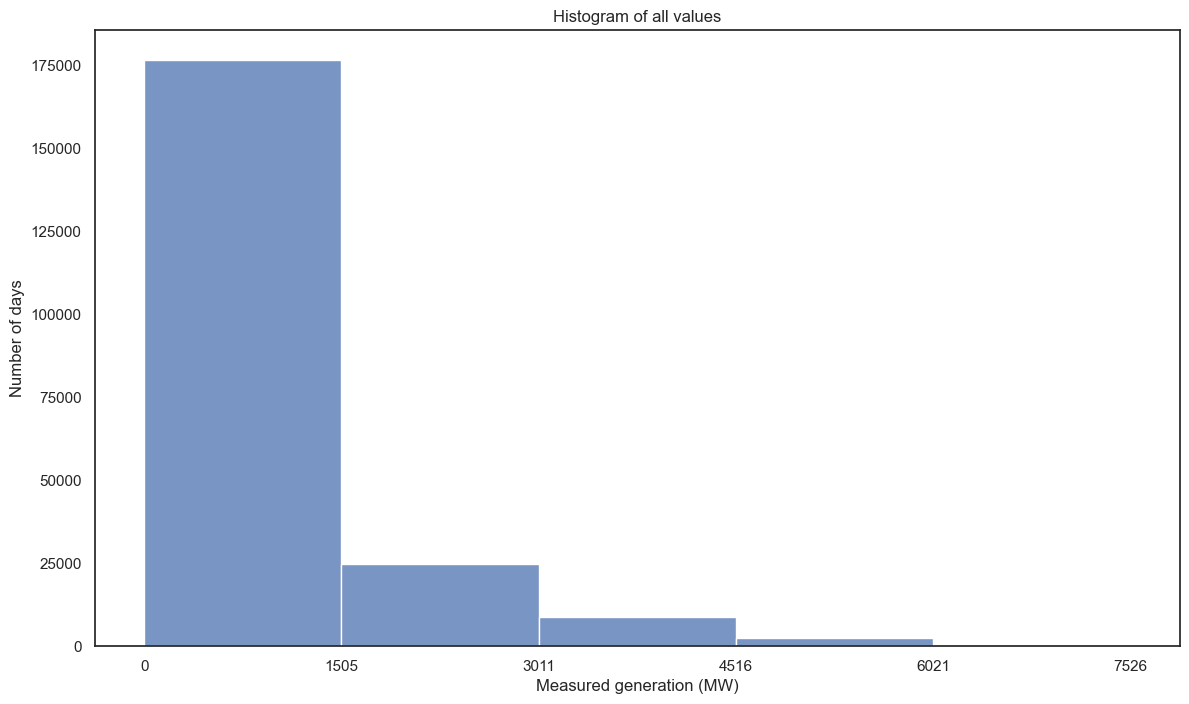

In [11]:
df_be_max = df_be.measured.max()
bins = [0, 0.2*df_be_max, 0.4*df_be_max, 0.6*df_be_max, 0.8*df_be_max, df_be_max]
plt.figure(figsize=(14,8))
sns.histplot(df_be.measured, bins=bins, kde=False)
plt.title('Histogram of all values')
plt.ylabel('Number of days')
plt.xlabel('Measured generation (MW)')
plt.xticks(bins)
plt.show()

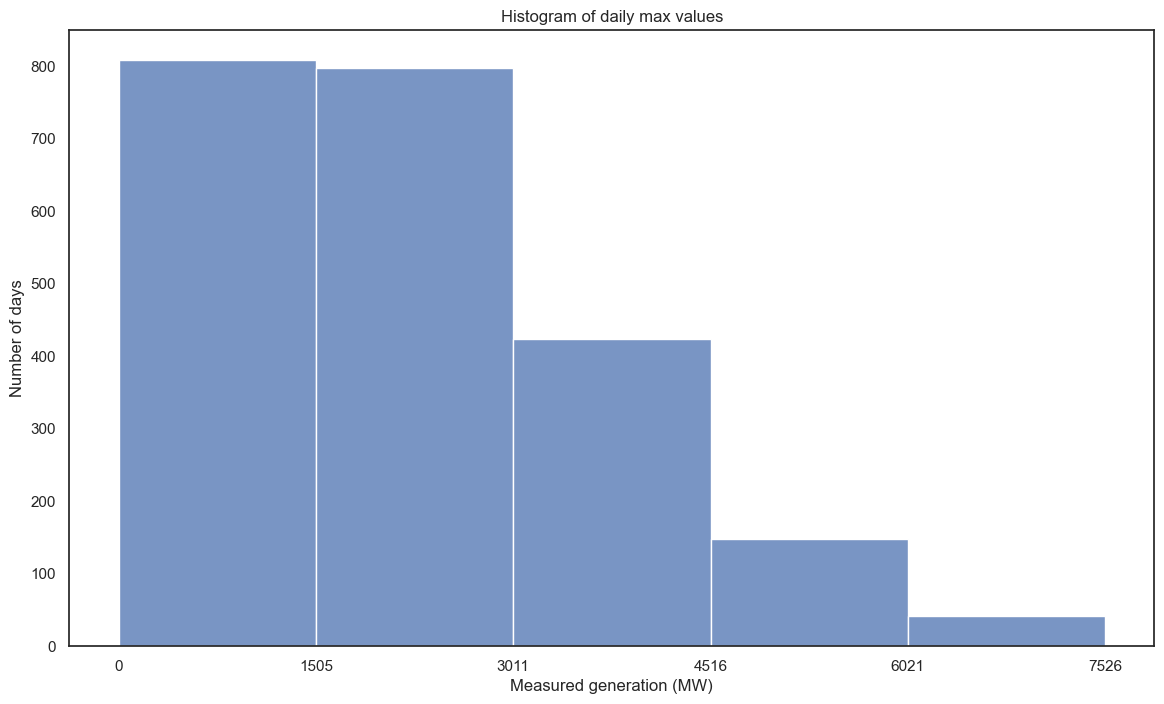

In [213]:
daily_max_df = df_be[['measured']].resample('D').max()
total_max = daily_max_df.measured.max()
bins = [0, 0.2*total_max, 0.4*total_max, 0.6*total_max, 0.8*total_max, total_max]
plt.figure(figsize=(14,8))
sns.histplot(daily_max_df.measured, bins=bins, kde=False)
plt.title('Histogram of daily max values')
plt.ylabel('Number of days')
plt.xlabel('Measured generation (MW)')
plt.xticks(bins)
plt.show()

In [51]:
daily_max = df_be.measured.resample('D').max().copy()
total_max = daily_max.max()

pc_80_100 = daily_max[daily_max >= total_max*0.8].index
pc_60_80 = daily_max[(daily_max >= total_max*0.6) & (daily_max < total_max*0.8)].index
pc_40_60 = daily_max[(daily_max >= total_max*0.4) & (daily_max < total_max*0.6)].index
pc_20_40 = daily_max[(daily_max >= total_max*0.2) & (daily_max < total_max*0.4)].index
pc_0_20 = daily_max[(daily_max < total_max*0.2)].index

df_pc_80_100 = daily_max[daily_max.index.normalize().isin(pc_80_100)]
df_pc_80_100 = df_pc_80_100.reset_index(drop=True)

df_pc_60_80 = daily_max[daily_max.index.normalize().isin(pc_60_80)]
df_pc_60_80 = df_pc_60_80.reset_index(drop=True)

df_pc_40_60 = daily_max[daily_max.index.normalize().isin(pc_40_60)]
df_pc_40_60 = df_pc_40_60.reset_index(drop=True)

df_pc_20_40 = daily_max[daily_max.index.normalize().isin(pc_20_40)]
df_pc_20_40 = df_pc_20_40.reset_index(drop=True)

df_pc_0_20 = daily_max[daily_max.index.normalize().isin(pc_0_20)]
df_pc_0_20 = df_pc_0_20.reset_index(drop=True)

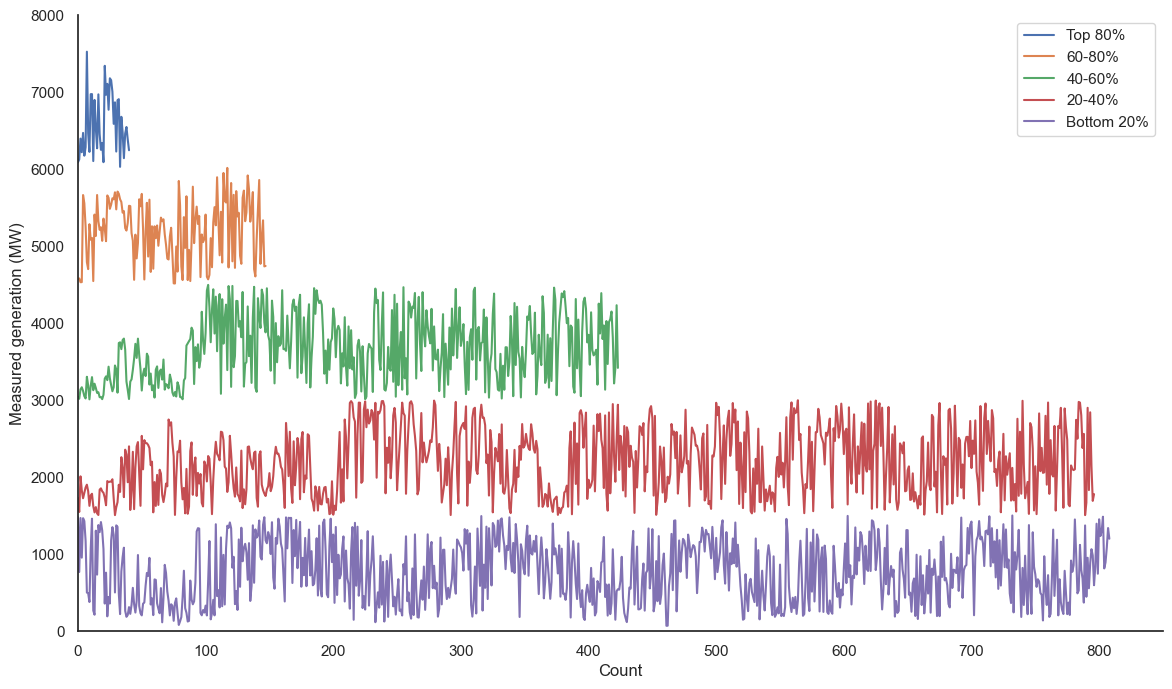

In [53]:
plt.figure(figsize=(14,8))
sns.lineplot(df_pc_80_100, label='Top 80%')
sns.lineplot(df_pc_60_80, label='60-80%')
sns.lineplot(df_pc_40_60, label='40-60%')
sns.lineplot(df_pc_20_40, label='20-40%')
sns.lineplot(df_pc_0_20, label='Bottom 20%')
sns.despine()
plt.ylabel('Measured generation (MW)')
plt.xlabel('Count')
plt.xlim(0,850)
plt.ylim(0,8000)
plt.legend(loc='upper right')
plt.show()

## Stationarity

In [12]:
adfuller(df_be.measured, autolag='AIC')

(-11.94507306500257,
 4.449909467141862e-22,
 82,
 212941,
 {'1%': -3.4303807098155406,
  '5%': -2.8615535733366726,
  '10%': -2.5667772245983227},
 2141580.3188957865)

# Their forecasts

### Plots

In [6]:
def plot_forecast_vs_measured(df, col_measured, col_forecast, title):
    region_max = df.groupby('region').measured.max().sort_values(ascending=False)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    axes_buffer = 200
    max_value = max(df[col_forecast].max(), df[col_measured].max())
    max_limit = np.ceil(max_value)+axes_buffer
    for region in region_max.index.values:
        ax = sns.regplot(df[df.region==region], y=col_measured, x=col_forecast, label=region)
    plt.plot([-axes_buffer, max_limit], [-axes_buffer, max_limit], color='black', linestyle='--', linewidth=1)
    plt.ylabel('Measured generation (MW)')
    plt.ylim(-axes_buffer, max_limit)
    plt.yticks(np.arange(0, (np.floor(max_value/1000)*1000)+1, 1000))
    plt.xlabel('Forecast generation (MW)')
    plt.xlim(-axes_buffer, max_limit)
    plt.xticks(np.arange(0, (np.floor(max_value/1000)*1000)+1, 1000))
    plt.legend(loc='upper left')
    plt.show()

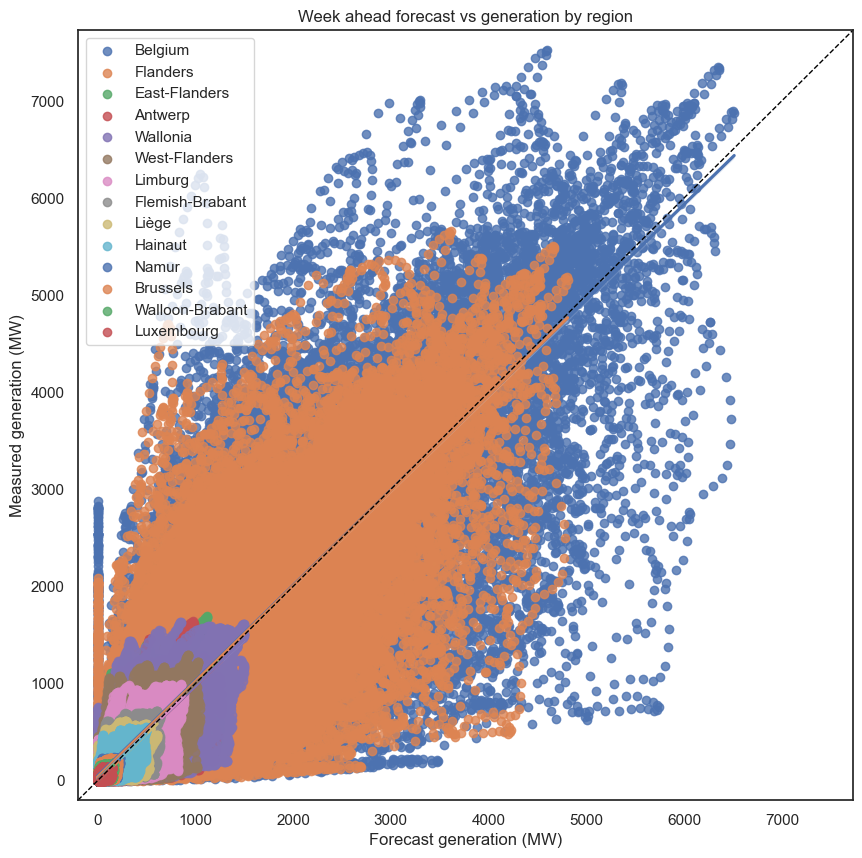

In [64]:
plot_forecast_vs_measured(df, 'measured', 'forecast_week', 'Week ahead forecast vs generation by region')

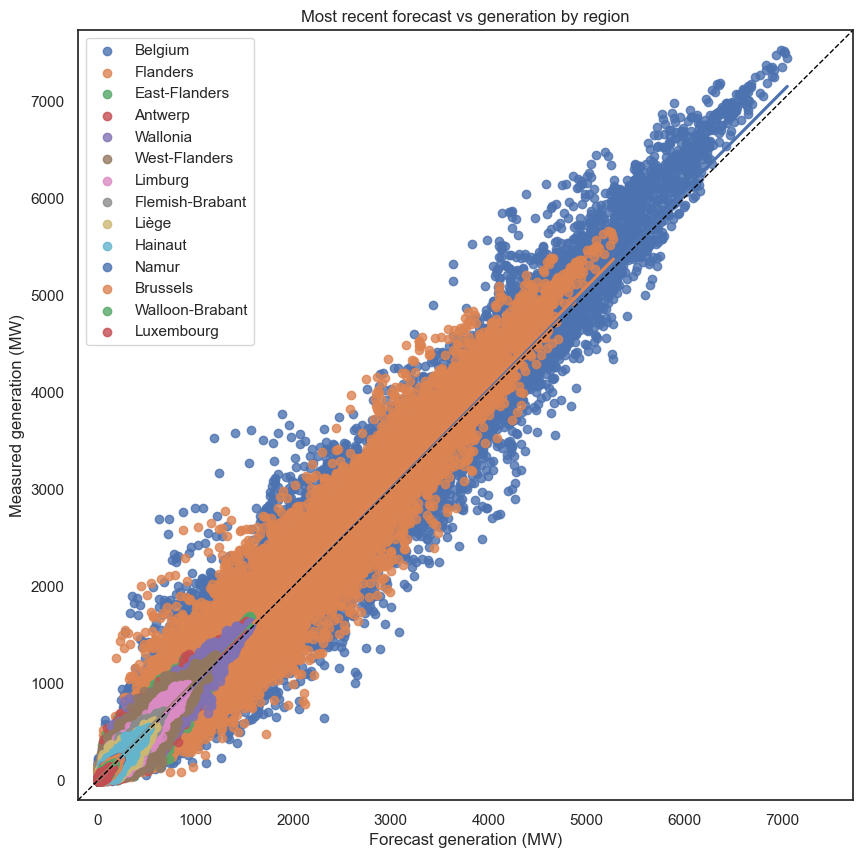

In [67]:
plot_forecast_vs_measured(df, 'measured', 'forecast_recent', 'Most recent forecast vs generation by region')

In [14]:
def plot_forecast_vs_measured_subplots(df, col_measured, col_forecast, title):
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)
    regions = df.region.unique()
    rows, cols = 4, 4
    for i, region in enumerate(regions, 1):
        ax = plt.subplot(rows, cols, i)
        region_data = df[df.region == region]
        max_value = max(region_data[col_forecast].max(), region_data[col_measured].max())
        max_limit = np.ceil(max_value)*1.1
        sns.regplot(data=region_data, x=col_forecast, y=col_measured)
        plt.plot([0, max_limit], [0, max_limit], color='black', linestyle='--', linewidth=1)
        plt.title(region)
        plt.ylabel('Measured generation (MW)')
        ax.set_ylim(-max_limit*0.1, max_limit)
        plt.xlabel('Forecast generation (MW)')
        ax.set_xlim(-max_limit*0.1, max_limit)
        ax.set_aspect('equal', adjustable='box')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

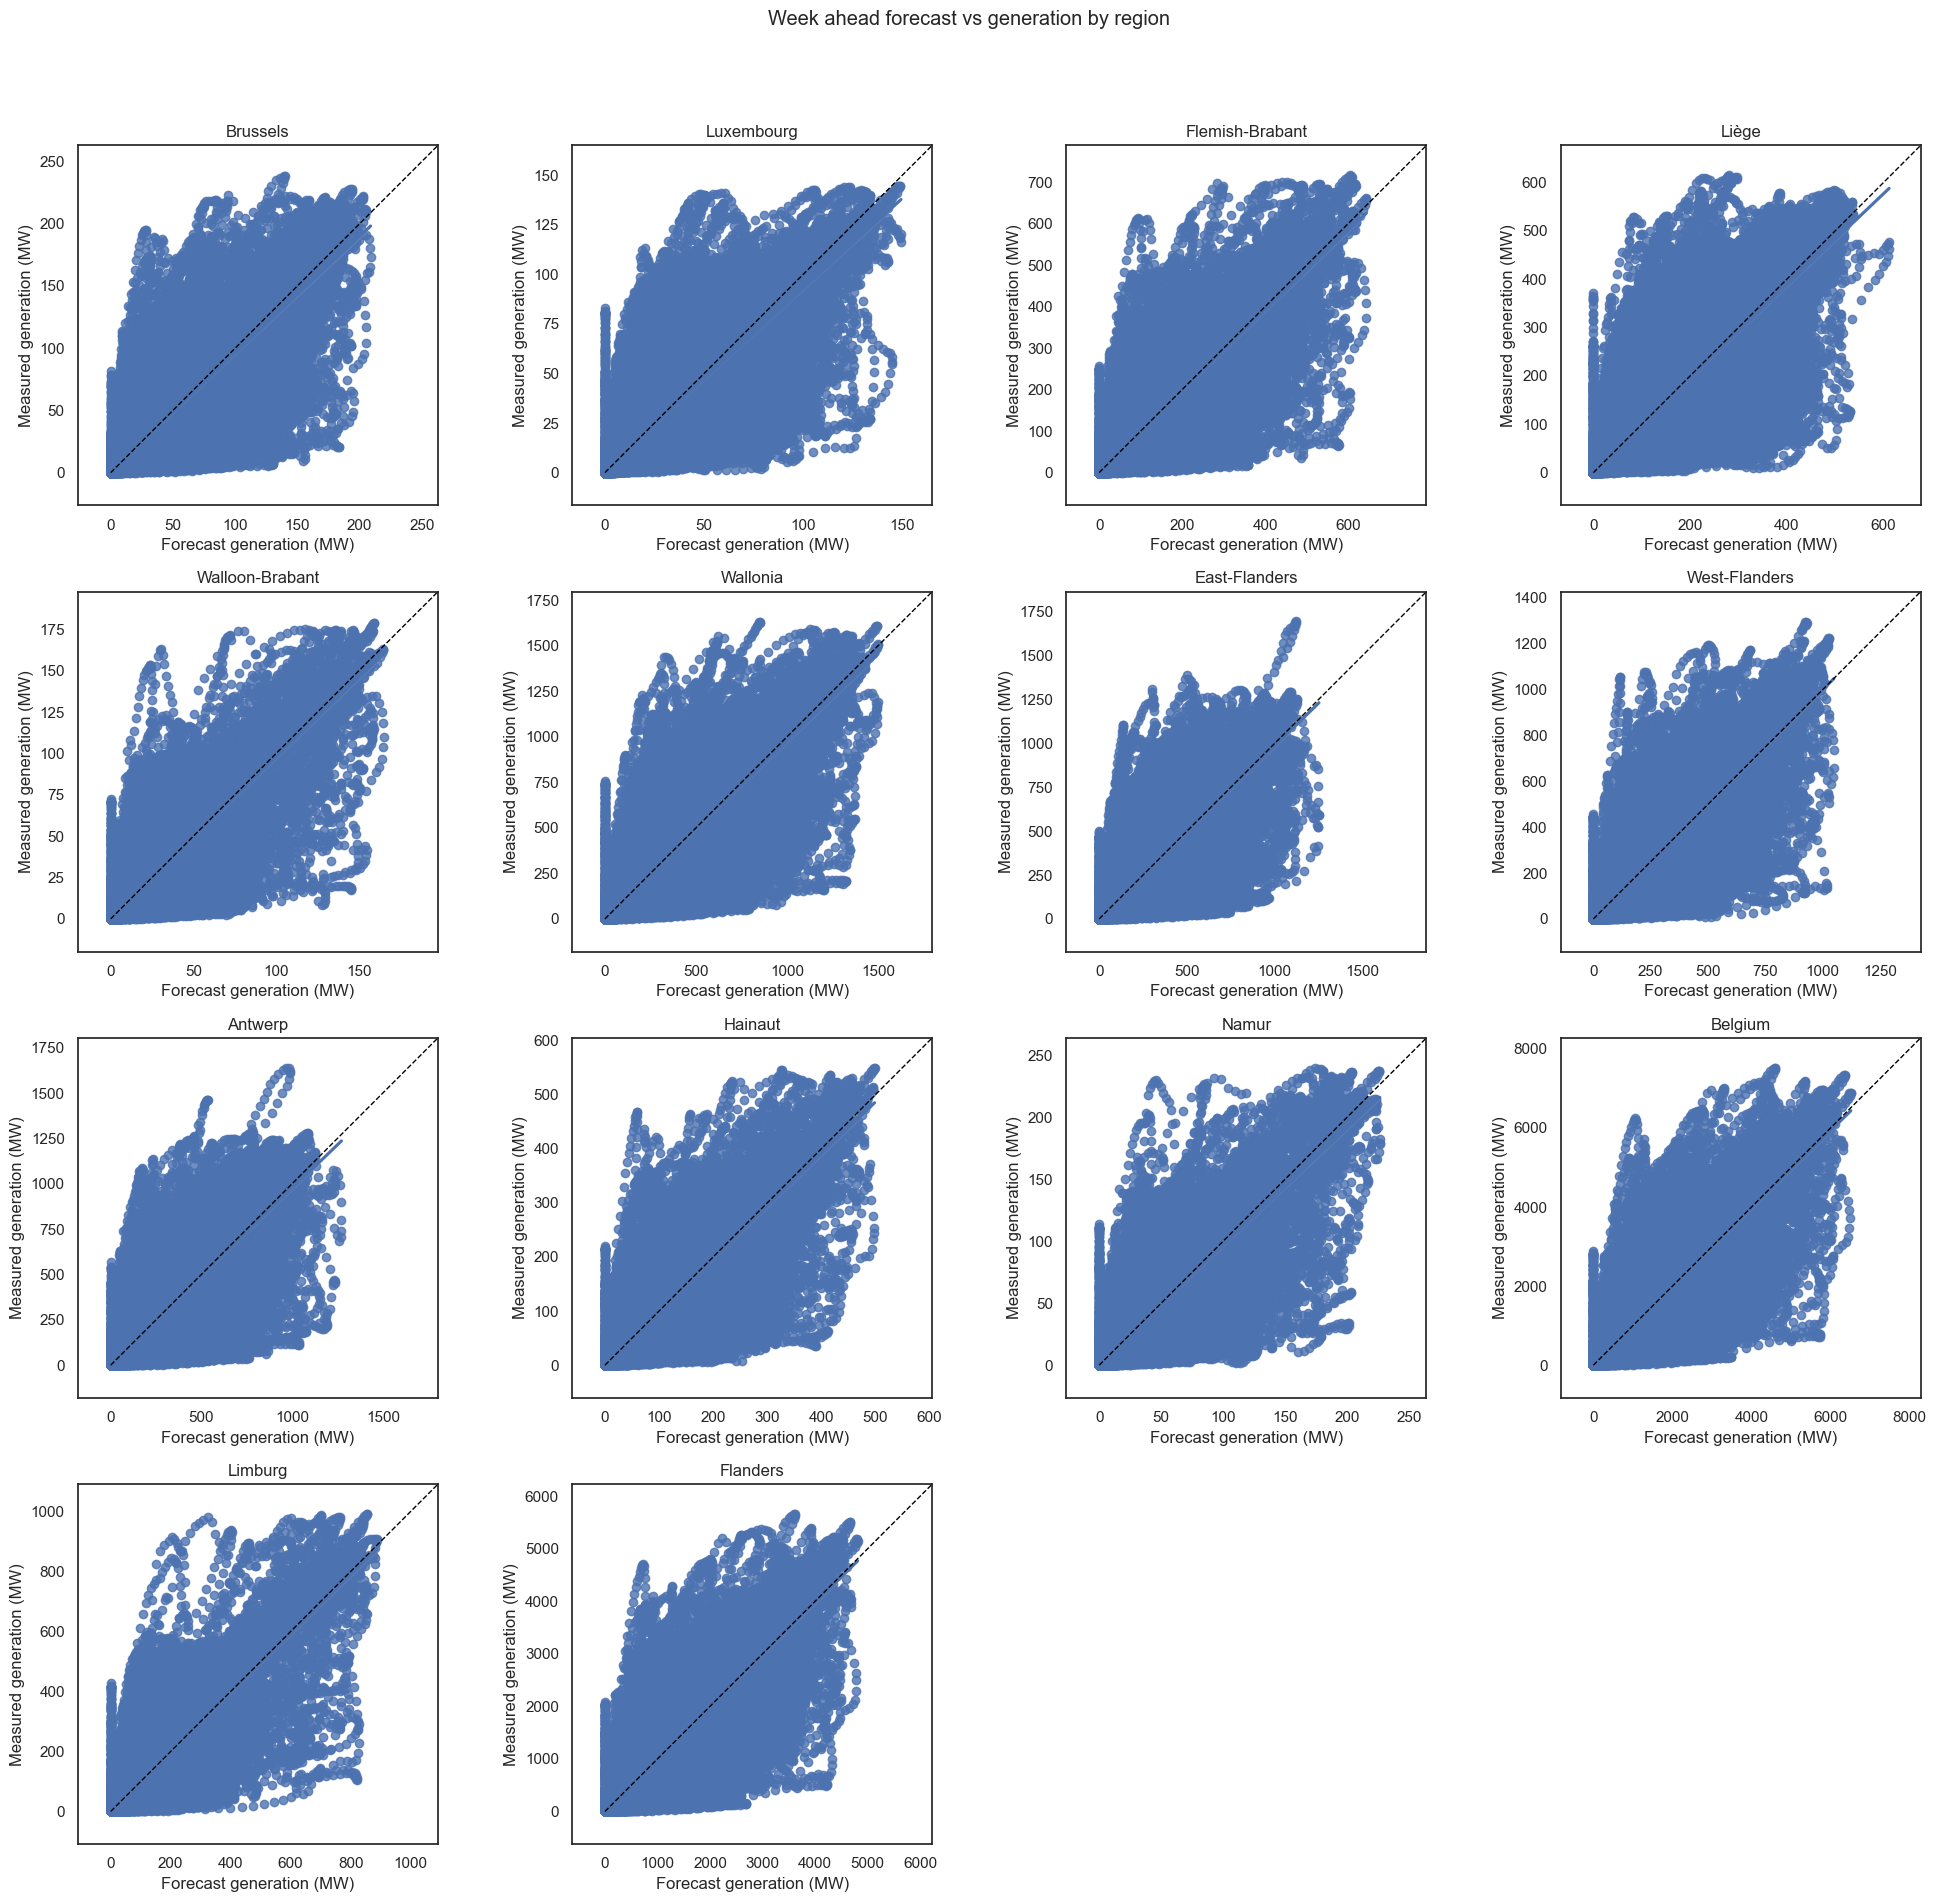

In [84]:
plot_forecast_vs_measured_subplots(df, 'measured', 'forecast_week', 'Week ahead forecast vs generation by region')

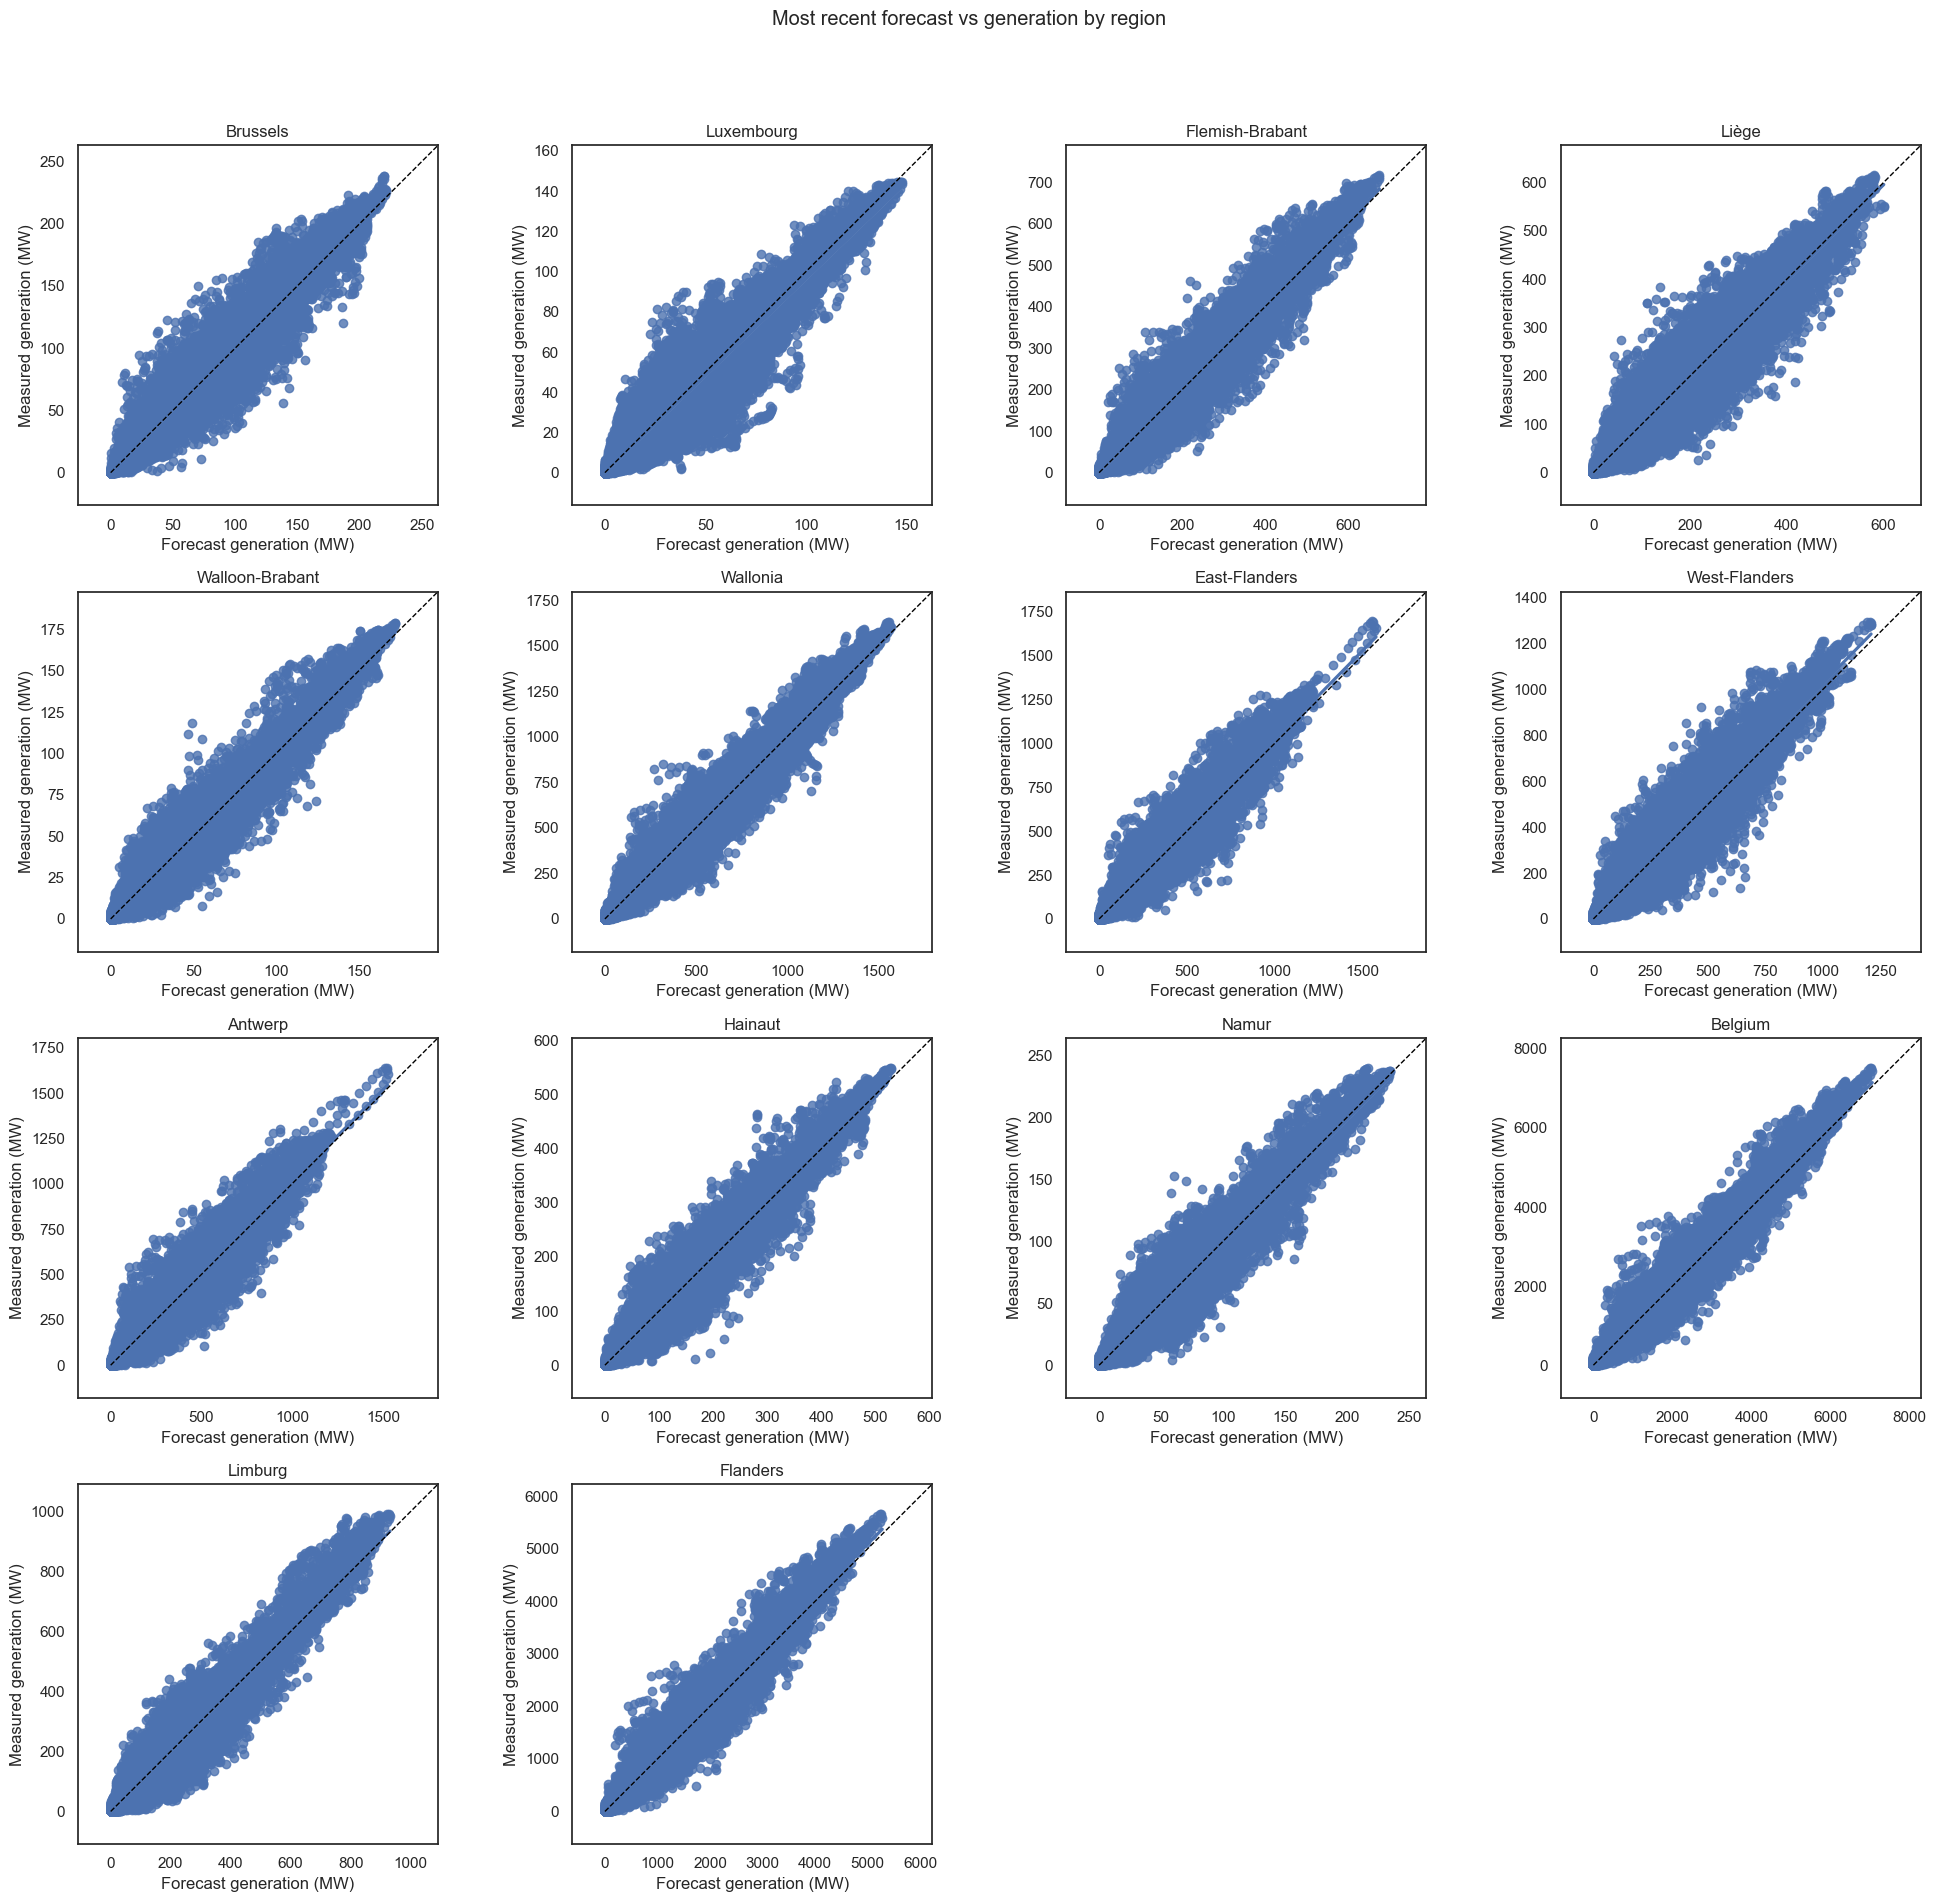

In [15]:
plot_forecast_vs_measured_subplots(df, 'measured', 'forecast_recent', 'Most recent forecast vs generation by region')

## Errors

### Overall stats

In [94]:
pd.merge(preds_vs_actual_stats_df(df_be.measured, df_be.forecast_week),preds_vs_actual_stats_df(df_be.measured, df_be.forecast_recent), on="Metric").rename(columns={'Value_x':'Week Ahead Forecast', 'Value_y':'Most Recent Forecast'})

Metric Week Ahead Forecast Most Recent Forecast
0             Mean (Actual)              646.47               646.47
1          Mean (Predicted)              609.10               641.21
2           Median (Actual)                2.29                 2.29
3        Median (Predicted)                5.91                 7.09
4             Mode (Actual)                   0                    0
5          Mode (Predicted)                   0                    0
6          Std Dev (Actual)             1108.59              1108.59
7       Std Dev (Predicted)             1010.08              1085.04
8           Positive Errors            52941.00             59863.00
9           Negative Errors            59831.00             52923.00
10               Mean Error              -37.37                -5.27
11                      MAE              224.32                63.00
12                      MSE           249249.65             19529.07
13                     RMSE              499.25               139.75
14             Median Error                   0                    0
15                    MedAE                2.59                 1.64
16               Mode Error                   0                    0
17            Std Dev Error              497.85               139.65
18                Min Error            -5193.69             -2337.12
19                Max Error             4998.91              1672.95
20           Mean Error (%)              119.59                63.40
21                     MAPE              137.42                71.79
22                    SMAPE               52.20                27.40
23            Min Error (%)             -100.00              -100.00
24            Max Error (%)          1703500.00           1188925.00
25  Mean Bias Deviation (%)               -5.78                -0.81
26                 R² Score                0.80                 0.98
27  Correlation Coefficient                0.89                 0.99
28                Theil's U                5.55                 1.55

In [11]:
df_be[(df_be.forecast_week - df_be.measured < -5190)]

measured  forecast_recent  forecast_day  \
datetime                                                             
2024-10-05 11:00:00+00:00  6246.909         6104.325      6254.191   

                           forecast_week  
datetime                                  
2024-10-05 11:00:00+00:00       1053.223

In [34]:
df_be[df_be.measured < 0.005].sort_values(by='forecast_week', ascending=False)

measured  forecast_recent  forecast_day  \
datetime                                                             
2018-11-22 07:30:00+00:00     0.004           47.561        38.253   
2023-10-20 06:15:00+00:00     0.002            2.950         3.189   
2024-09-14 05:15:00+00:00     0.000           23.092        24.402   
2023-05-26 03:45:00+00:00     0.000           36.890        36.933   
2024-04-23 04:30:00+00:00     0.000           25.103        23.341   
...                             ...              ...           ...   
2020-10-09 19:15:00+00:00     0.000            0.000         0.000   
2020-10-09 19:00:00+00:00     0.000            0.000         0.000   
2020-10-09 18:45:00+00:00     0.000            0.000         0.000   
2020-10-09 18:30:00+00:00     0.000            0.000         0.000   
2024-10-27 23:45:00+00:00     0.000            0.000         0.000   

                           forecast_week  
datetime                                  
2018-11-22 07:30:00+00:00         26.954  
2023-10-20 06:15:00+00:00         23.968  
2024-09-14 05:15:00+00:00         21.278  
2023-05-26 03:45:00+00:00         21.253  
2024-04-23 04:30:00+00:00         20.645  
...                                  ...  
2020-10-09 19:15:00+00:00          0.000  
2020-10-09 19:00:00+00:00          0.000  
2020-10-09 18:45:00+00:00          0.000  
2020-10-09 18:30:00+00:00          0.000  
2024-10-27 23:45:00+00:00          0.000  

[102332 rows x 4 columns]

In [97]:
preds_vs_actual_stats_df(df_be.measured[df_be.measured > 0.01*df_be.measured.max()], df_be.forecast_week[df_be.measured > 0.01*df_be.measured.max()])

Metric      Value
0             Mean (Actual)    1437.06
1          Mean (Predicted)    1347.60
2           Median (Actual)    1075.14
3        Median (Predicted)    1053.80
4             Mode (Actual)     111.92
5          Mode (Predicted)          0
6          Std Dev (Actual)    1266.81
7       Std Dev (Predicted)    1132.12
8           Positive Errors   40468.00
9           Negative Errors   55123.00
10               Mean Error     -89.46
11                      MAE     493.10
12                      MSE  553401.24
13                     RMSE     743.91
14             Median Error     -53.28
15                    MedAE     301.42
16               Mode Error      -2.83
17            Std Dev Error     738.52
18                Min Error   -5193.69
19                Max Error    4998.91
20           Mean Error (%)      22.07
21                     MAPE      55.71
22                    SMAPE      41.71
23            Min Error (%)    -100.00
24            Max Error (%)    2589.95
25  Mean Bias Deviation (%)      -6.22
26                 R² Score       0.66
27  Correlation Coefficient       0.82
28                Theil's U       5.58

In [ ]:
df_be[(df_be.measured > 0) & (df_be.forecast_week == 0)].sort_values('measured')

measured  forecast_recent  forecast_day  \
datetime                                                             
2024-05-11 19:30:00+00:00     0.001            0.000         0.000   
2024-05-28 20:30:00+00:00     0.001            0.000         0.000   
2021-07-13 03:30:00+00:00     0.001            0.000         0.000   
2022-08-28 18:45:00+00:00     0.001            0.000         0.000   
2022-08-27 18:45:00+00:00     0.001            0.000         0.000   
...                             ...              ...           ...   
2021-04-01 12:45:00+00:00  2805.278         2819.435      2993.268   
2021-04-01 13:00:00+00:00  2808.270         2768.048      2937.239   
2021-04-01 12:15:00+00:00  2822.197         2886.976      3064.942   
2021-04-01 12:00:00+00:00  2825.932         2893.899      3071.109   
2021-09-23 11:30:00+00:00  2879.877         2621.654      2658.755   

                           forecast_week  
datetime                                  
2024-05-11 19:30:00+00:00            0.0  
2024-05-28 20:30:00+00:00            0.0  
2021-07-13 03:30:00+00:00            0.0  
2022-08-28 18:45:00+00:00            0.0  
2022-08-27 18:45:00+00:00            0.0  
...                                  ...  
2021-04-01 12:45:00+00:00            0.0  
2021-04-01 13:00:00+00:00            0.0  
2021-04-01 12:15:00+00:00            0.0  
2021-04-01 12:00:00+00:00            0.0  
2021-09-23 11:30:00+00:00            0.0  

[2526 rows x 4 columns]

#### Error stats to df

In [95]:
df_errs = df_be[['forecast_week','forecast_recent','measured']]
df_errs = df_errs[df_errs.measured != 0]
df_errs = df_errs.dropna()

df_errs['forecast_week_error'] = df_errs.measured - df_errs.forecast_week
df_errs['forecast_week_error_pc'] = np.divide(
    df_errs.forecast_week_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_week_error),
    where=df_errs.measured != 0
) * 100
df_errs['forecast_week_abs_error_pc'] = np.divide(
    np.abs(df_errs.forecast_week_error),
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_week_error),
    where=df_errs.measured != 0
) * 100

df_errs['forecast_recent_error'] = df_errs.measured - df_errs.forecast_recent
df_errs['forecast_recent_error_pc'] = np.divide(
    df_errs.forecast_recent_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_recent_error),
    where=df_errs.measured != 0
) * 100
df_errs['forecast_recent_abs_error_pc'] = np.divide(
    np.abs(df_errs.forecast_recent_error),
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_recent_error),
    where=df_errs.measured != 0
) * 100

df_errs = df_errs[['measured', 'forecast_week', 'forecast_week_error', 'forecast_week_error_pc', 'forecast_week_abs_error_pc', 'forecast_recent', 'forecast_recent_error', 'forecast_recent_error_pc', 'forecast_recent_abs_error_pc']]

In [96]:
df_errs.sort_values(by='forecast_week_error_pc', ascending=True).head(5)[['measured','forecast_week','forecast_week_error_pc']]

measured  forecast_week  forecast_week_error_pc
datetime                                                                  
2023-11-13 07:00:00+00:00     0.001         17.036              -1703500.0
2024-02-11 07:00:00+00:00     0.001         12.439              -1243800.0
2023-10-20 06:15:00+00:00     0.002         23.968              -1198300.0
2018-11-22 07:30:00+00:00     0.004         26.954               -673750.0
2018-10-30 06:30:00+00:00     0.001          5.398               -539700.0

### Regional stats

In [41]:
df.region.unique()

array(['Brussels', 'Luxembourg', 'Flemish-Brabant', 'Liège',
       'Walloon-Brabant', 'Wallonia', 'East-Flanders', 'West-Flanders',
       'Antwerp', 'Hainaut', 'Namur', 'Belgium', 'Limburg', 'Flanders'],
      dtype=object)

In [50]:
# order regions by location
chosen_region_order = ['West-Flanders', 'East-Flanders', 'Antwerp', 'Flemish-Brabant', 'Limburg',
                        'Brussels',
                        'Hainaut', 'Walloon-Brabant', 'Namur', 'Liège', 'Luxembourg'
                        # 'Flanders', 'Wallonia', 'Belgium'
]

In [58]:
def stats_by_timeframe(df_in, timeframe):
    df_stats_by_region = pd.DataFrame()

    for region in chosen_region_order:
        region_data = df_in[df_in.region == region]
        stats = preds_vs_actual_stats(region_data.measured, region_data[timeframe])
        stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
        region_df = pd.DataFrame(stats_formatted, columns=[region])
        if df_stats_by_region.empty:
            df_stats_by_region = region_df
        else:
            df_stats_by_region = pd.concat([df_stats_by_region, region_df], axis=1)

    df_stats_by_region.index = stats_column_order

    return df_stats_by_region

In [61]:
df_stats_by_region_week = stats_by_timeframe(df, 'forecast_week').T
df_stats_by_region_week

Mean (Actual) Mean (Predicted) Median (Actual)  \
West-Flanders          106.32            98.66            0.24   
East-Flanders          117.73           110.31            0.26   
Antwerp                115.88           109.36            0.23   
Flemish-Brabant         57.84            54.56            0.12   
Limburg                 77.54            73.05            0.16   
Brussels                14.75            14.08            0.02   
Hainaut                 45.69            43.28            0.13   
Walloon-Brabant         14.07            13.26            0.03   
Namur                   20.89            20.04            0.04   
Liège                   60.78            57.71            0.13   
Luxembourg              14.98            14.81            0.03   

                Median (Predicted) Mode (Actual) Mode (Predicted)  \
West-Flanders                 0.93             0                0   
East-Flanders                 1.00             0                0   
Antwerp                       0.99             0                0   
Flemish-Brabant               0.50             0                0   
Limburg                       0.72             0                0   
Brussels                      0.09             0                0   
Hainaut                       0.40             0                0   
Walloon-Brabant               0.13             0                0   
Namur                         0.19             0                0   
Liège                         0.55             0                0   
Luxembourg                    0.14             0                0   

                Std Dev (Actual) Std Dev (Predicted) Positive Errors  \
West-Flanders             184.87              164.43        50884.00   
East-Flanders             208.07              187.73        51970.00   
Antwerp                   204.90              185.75        53097.00   
Flemish-Brabant           101.56               92.66        52557.00   
Limburg                   132.55              119.75        52893.00   
Brussels                   31.18               29.10        52742.00   
Hainaut                    79.47               72.97        52675.00   
Walloon-Brabant            24.16               22.08        52324.00   
Namur                      35.29               32.86        54222.00   
Liège                     103.35               95.27        53144.00   
Luxembourg                 24.88               24.11        56034.00   

                Negative Errors Mean Error    MAE       MSE    RMSE  \
West-Flanders          60126.00      -7.66  39.54   7677.58   87.62   
East-Flanders          59288.00      -7.42  43.85   9845.75   99.23   
Antwerp                58237.00      -6.52  43.95  10034.83  100.17   
Flemish-Brabant        58326.00      -3.29  21.64   2379.43   48.78   
Limburg                58288.00      -4.49  28.68   3907.41   62.51   
Brussels               57573.00      -0.68   5.71    224.49   14.98   
Hainaut                58531.00      -2.41  16.49   1366.42   36.97   
Walloon-Brabant        57940.00      -0.82   5.25    133.72   11.56   
Namur                  56446.00      -0.85   7.70    284.76   16.87   
Liège                  57883.00      -3.07  22.42   2488.50   49.88   
Luxembourg             54295.00      -0.17   5.40    139.42   11.81   

                Median Error MedAE Mode Error Std Dev Error Min Error  \
West-Flanders              0  0.47          0         87.29   -940.91   
East-Flanders              0  0.47          0         98.95  -1005.73   
Antwerp                    0  0.47          0         99.96   -933.43   
Flemish-Brabant            0  0.24          0         48.67   -519.72   
Limburg                    0  0.36          0         62.35   -709.79   
Brussels                   0  0.04          0         14.97   -167.68   
Hainaut                    0  0.18          0         36.89   -408.82   
Walloon-Brabant            0  0.06          0         11.53   -132.71   
Namur              

In [62]:
df_stats_by_region_recent = stats_by_timeframe(df, 'forecast_recent').T
df_stats_by_region_recent

Mean (Actual) Mean (Predicted) Median (Actual)  \
West-Flanders          106.32           103.76            0.24   
East-Flanders          117.73           115.99            0.26   
Antwerp                115.88           115.22            0.23   
Flemish-Brabant         57.84            57.35            0.12   
Limburg                 77.54            77.50            0.16   
Brussels                14.75            14.62            0.02   
Hainaut                 45.69            45.45            0.13   
Walloon-Brabant         14.07            13.95            0.03   
Namur                   20.89            21.04            0.04   
Liège                   60.78            60.91            0.13   
Luxembourg              14.98            15.42            0.03   

                Median (Predicted) Mode (Actual) Mode (Predicted)  \
West-Flanders                 1.09             0                0   
East-Flanders                 1.20             0                0   
Antwerp                       1.18             0                0   
Flemish-Brabant               0.60             0                0   
Limburg                       0.84             0                0   
Brussels                      0.11             0                0   
Hainaut                       0.48             0                0   
Walloon-Brabant               0.15             0                0   
Namur                         0.23             0                0   
Liège                         0.66             0                0   
Luxembourg                    0.17             0                0   

                Std Dev (Actual) Std Dev (Predicted) Positive Errors  \
West-Flanders             184.87              177.21        55140.00   
East-Flanders             208.07              201.72        57369.00   
Antwerp                   204.90              199.98        60384.00   
Flemish-Brabant           101.56               99.19        59038.00   
Limburg                   132.55              130.16        60666.00   
Brussels                   31.18               30.54        58723.00   
Hainaut                    79.47               78.18        59289.00   
Walloon-Brabant            24.16               23.68        58141.00   
Namur                      35.29               35.16        62504.00   
Liège                     103.35              102.67        60565.00   
Luxembourg                 24.88               25.40        65051.00   

                Negative Errors Mean Error    MAE      MSE   RMSE  \
West-Flanders          55843.00      -2.57  14.89  1132.19  33.65   
East-Flanders          53866.00      -1.75  14.53  1094.44  33.08   
Antwerp                50944.00      -0.65  14.30  1078.29  32.84   
Flemish-Brabant        51816.00      -0.49   6.95   249.63  15.80   
Limburg                50498.00      -0.04  10.02   497.40  22.30   
Brussels               51544.00      -0.13   1.92    25.45   5.04   
Hainaut                51886.00      -0.24   5.29   140.36  11.85   
Walloon-Brabant        52091.00      -0.12   1.77    15.58   3.95   
Namur                  48125.00       0.15   2.63    32.95   5.74   
Liège                  50428.00       0.13   8.17   323.55  17.99   
Luxembourg             45255.00       0.44   2.20    22.93   4.79   

                Median Error MedAE Mode Error Std Dev Error Min Error  \
West-Flanders              0  0.31          0         33.55   -454.18   
East-Flanders              0  0.30          0         33.04   -447.87   
Antwerp                    0  0.30          0         32.83   -461.35   
Flemish-Brabant            0  0.16          0         15.79   -242.31   
Limburg                    0  0.22          0         22.30   -248.86   
Brussels                   0  0.03          0          5.04    -79.61   
Hainaut                    0  0.12          0         11.85   -183.06   
Walloon-Brabant            0  0.04          0          3.95    -69.31   
Namur                      0  0.06         

#### Including region areas

In [68]:
region_areas_df = pd.DataFrame({
    "Region": [
        'West-Flanders', 'East-Flanders', 'Antwerp', 'Flemish-Brabant', 'Limburg',
        'Brussels',
        'Hainaut', 'Walloon-Brabant', 'Namur', 'Liège', 'Luxembourg'
        # , "Wallonia", "Flanders", "Belgium"
    ],
    "Area": [
        3197, 3007, 2876, 2118, 2427,
        162,
        3813, 1097, 3675, 3857, 4459
        # , 16901, 13626, 30689
    ]
})
region_areas_df

Region  Area
0     West-Flanders  3197
1     East-Flanders  3007
2           Antwerp  2876
3   Flemish-Brabant  2118
4           Limburg  2427
5          Brussels   162
6           Hainaut  3813
7   Walloon-Brabant  1097
8             Namur  3675
9             Liège  3857
10       Luxembourg  4459

In [71]:
df_stats_by_region_week_with_area = pd.merge(region_areas_df, df_stats_by_region_week.reset_index().rename(columns={'index':'Region'}), on="Region", how="outer")
df_stats_by_region_week_with_area['Region'] = pd.Categorical(df_stats_by_region_week_with_area['Region'], categories=region_areas_df['Region'], ordered=True)
df_stats_by_region_week_with_area = df_stats_by_region_week_with_area.sort_values('Region').reset_index(drop=True)
df_stats_by_region_week_with_area

Region  Area Mean (Actual) Mean (Predicted) Median (Actual)  \
0     West-Flanders  3197        106.32            98.66            0.24   
1     East-Flanders  3007        117.73           110.31            0.26   
2           Antwerp  2876        115.88           109.36            0.23   
3   Flemish-Brabant  2118         57.84            54.56            0.12   
4           Limburg  2427         77.54            73.05            0.16   
5          Brussels   162         14.75            14.08            0.02   
6           Hainaut  3813         45.69            43.28            0.13   
7   Walloon-Brabant  1097         14.07            13.26            0.03   
8             Namur  3675         20.89            20.04            0.04   
9             Liège  3857         60.78            57.71            0.13   
10       Luxembourg  4459         14.98            14.81            0.03   

   Median (Predicted) Mode (Actual) Mode (Predicted) Std Dev (Actual)  \
0                0.93             0                0           184.87   
1                1.00             0                0           208.07   
2                0.99             0                0           204.90   
3                0.50             0                0           101.56   
4                0.72             0                0           132.55   
5                0.09             0                0            31.18   
6                0.40             0                0            79.47   
7                0.13             0                0            24.16   
8                0.19             0                0            35.29   
9                0.55             0                0           103.35   
10               0.14             0                0            24.88   

   Std Dev (Predicted) Positive Errors Negative Errors Mean Error    MAE  \
0               164.43        50884.00        60126.00      -7.66  39.54   
1               187.73        51970.00        59288.00      -7.42  43.85   
2               185.75        53097.00        58237.00      -6.52  43.95   
3                92.66        52557.00        58326.00      -3.29  21.64   
4               119.75        52893.00        58288.00      -4.49  28.68   
5                29.10        52742.00        57573.00      -0.68   5.71   
6                72.97        52675.00        58531.00      -2.41  16.49   
7                22.08        52324.00        57940.00      -0.82   5.25   
8                32.86        54222.00        56446.00      -0.85   7.70   
9                95.27        53144.00        57883.00      -3.07  22.42   
10               24.11        56034.00        54295.00      -0.17   5.40   

         MSE    RMSE Median Error MedAE Mode Error Std Dev Error Min Error  \
0    7677.58   87.62            0  0.47          0         87.29   -940.91   
1    9845.75   99.23            0  0.47          0         98.95  -1005.73   
2   10034.83  100.17            0  0.47          0         99.96   -933.43   
3    2379.43   48.78            0  0.24          0         48.67   -519.72   
4    3907.41   62.51            0  0.36          0         62.35   -709.79   
5     224.49   14.98            0  0.04          0         14.97   -167.68   
6    1366.42   36.97            0  0.18          0         36.89   -408.82   
7     133.72   11.56            0  0.06          0         11.53   -132.71   
8     284.76   16.87            0  0.09          0         16.85   -185.19   
9    2488.50   49.88            0  0.27          0         49.79   -447.53   
10    139.42   11.81            0  0.07          0         11.81    -94.44   

   Max Error Mean Error (%)    MAPE  SMAPE Min Error (%) Max Error (%)  \
0     883.08         120.00  138.36  54.52       -100.00    2345400.00   
1     901.88         108.18  126.21  54.39       -100.00     783700.00   
2     977.54         123.92  141.67  55.02       -100.00    3427500.00   
3     511.64          90.11  107.65  54.08       -100.00     446400.00   
4  

In [72]:
df_stats_by_region_recent_with_area = pd.merge(region_areas_df, df_stats_by_region_recent.reset_index().rename(columns={'index':'Region'}), on="Region", how="outer")
df_stats_by_region_recent_with_area['Region'] = pd.Categorical(df_stats_by_region_recent_with_area['Region'], categories=region_areas_df['Region'], ordered=True)
df_stats_by_region_recent_with_area = df_stats_by_region_recent_with_area.sort_values('Region').reset_index(drop=True)
df_stats_by_region_recent_with_area

Region  Area Mean (Actual) Mean (Predicted) Median (Actual)  \
0     West-Flanders  3197        106.32           103.76            0.24   
1     East-Flanders  3007        117.73           115.99            0.26   
2           Antwerp  2876        115.88           115.22            0.23   
3   Flemish-Brabant  2118         57.84            57.35            0.12   
4           Limburg  2427         77.54            77.50            0.16   
5          Brussels   162         14.75            14.62            0.02   
6           Hainaut  3813         45.69            45.45            0.13   
7   Walloon-Brabant  1097         14.07            13.95            0.03   
8             Namur  3675         20.89            21.04            0.04   
9             Liège  3857         60.78            60.91            0.13   
10       Luxembourg  4459         14.98            15.42            0.03   

   Median (Predicted) Mode (Actual) Mode (Predicted) Std Dev (Actual)  \
0                1.09             0                0           184.87   
1                1.20             0                0           208.07   
2                1.18             0                0           204.90   
3                0.60             0                0           101.56   
4                0.84             0                0           132.55   
5                0.11             0                0            31.18   
6                0.48             0                0            79.47   
7                0.15             0                0            24.16   
8                0.23             0                0            35.29   
9                0.66             0                0           103.35   
10               0.17             0                0            24.88   

   Std Dev (Predicted) Positive Errors Negative Errors Mean Error    MAE  \
0               177.21        55140.00        55843.00      -2.57  14.89   
1               201.72        57369.00        53866.00      -1.75  14.53   
2               199.98        60384.00        50944.00      -0.65  14.30   
3                99.19        59038.00        51816.00      -0.49   6.95   
4               130.16        60666.00        50498.00      -0.04  10.02   
5                30.54        58723.00        51544.00      -0.13   1.92   
6                78.18        59289.00        51886.00      -0.24   5.29   
7                23.68        58141.00        52091.00      -0.12   1.77   
8                35.16        62504.00        48125.00       0.15   2.63   
9               102.67        60565.00        50428.00       0.13   8.17   
10               25.40        65051.00        45255.00       0.44   2.20   

        MSE   RMSE Median Error MedAE Mode Error Std Dev Error Min Error  \
0   1132.19  33.65            0  0.31          0         33.55   -454.18   
1   1094.44  33.08            0  0.30          0         33.04   -447.87   
2   1078.29  32.84            0  0.30          0         32.83   -461.35   
3    249.63  15.80            0  0.16          0         15.79   -242.31   
4    497.40  22.30            0  0.22          0         22.30   -248.86   
5     25.45   5.04            0  0.03          0          5.04    -79.61   
6    140.36  11.85            0  0.12          0         11.85   -183.06   
7     15.58   3.95            0  0.04          0          3.95    -69.31   
8     32.95   5.74            0  0.06          0          5.74    -92.37   
9    323.55  17.99            0  0.19          0         17.99   -244.99   
10    22.93   4.79            0  0.05          0          4.77    -55.62   

   Max Error Mean Error (%)   MAPE  SMAPE Min Error (%) Max Error (%)  \
0     505.04          73.03  83.25  31.74       -100.00     434000.00   
1     509.49          66.26  75.35  29.98       -100.00     437200.00   
2     429.61          58.44  66.95  30.24       -100.00     444200.00   
3     182.92          45.22  53.51  28.98       -100.00     156400.00   
4     253.51          43.12  52.

In [75]:
df_region_normalised_by_area = pd.merge(region_areas_df, df.rename(columns={'region':'Region'}), on="Region", how="outer")
for col in ['measured', 'forecast_recent', 'forecast_week']:
    df_region_normalised_by_area[col] = df_region_normalised_by_area[col] / df_region_normalised_by_area['Area']
df_region_normalised_by_area = df_region_normalised_by_area.drop(columns=['Area'])
df_region_normalised_by_area = df_region_normalised_by_area.rename(columns={'Region':'region'})

In [77]:
stats_by_timeframe(df_region_normalised_by_area, 'forecast_week').T

Mean (Actual) Mean (Predicted) Median (Actual)  \
West-Flanders            0.03             0.03         7.6e-05   
East-Flanders            0.04             0.04         8.5e-05   
Antwerp                  0.04             0.04           8e-05   
Flemish-Brabant          0.03             0.03         5.8e-05   
Limburg                  0.03             0.03         6.7e-05   
Brussels                 0.09             0.09         0.00011   
Hainaut                  0.01             0.01         3.4e-05   
Walloon-Brabant          0.01             0.01         2.7e-05   
Namur                  0.0057           0.0055         1.1e-05   
Liège                    0.02             0.01         3.4e-05   
Luxembourg             0.0034           0.0033         6.7e-06   

                Median (Predicted) Mode (Actual) Mode (Predicted)  \
West-Flanders              0.00029             0                0   
East-Flanders              0.00033             0                0   
Antwerp                    0.00035             0                0   
Flemish-Brabant            0.00024             0                0   
Limburg                     0.0003             0                0   
Brussels                   0.00055             0                0   
Hainaut                    0.00011             0                0   
Walloon-Brabant            0.00012             0                0   
Namur                      5.3e-05             0                0   
Liège                      0.00014             0                0   
Luxembourg                 3.2e-05             0                0   

                Std Dev (Actual) Std Dev (Predicted) Positive Errors  \
West-Flanders               0.06                0.05        50884.00   
East-Flanders               0.07                0.06        51970.00   
Antwerp                     0.07                0.06        53097.00   
Flemish-Brabant             0.05                0.04        52557.00   
Limburg                     0.05                0.05        52893.00   
Brussels                    0.19                0.18        52742.00   
Hainaut                     0.02                0.02        52675.00   
Walloon-Brabant             0.02                0.02        52324.00   
Namur                     0.0096              0.0089        54222.00   
Liège                       0.03                0.02        53144.00   
Luxembourg                0.0056              0.0054        56034.00   

                Negative Errors Mean Error     MAE      MSE    RMSE  \
West-Flanders          60126.00    -0.0024    0.01  0.00075    0.03   
East-Flanders          59288.00    -0.0025    0.01   0.0011    0.03   
Antwerp                58237.00    -0.0023    0.02   0.0012    0.03   
Flemish-Brabant        58326.00    -0.0016    0.01  0.00053    0.02   
Limburg                58288.00    -0.0018    0.01  0.00066    0.03   
Brussels               57573.00    -0.0042    0.04   0.0086    0.09   
Hainaut                58531.00   -0.00063  0.0043  9.4e-05  0.0097   
Walloon-Brabant        57940.00   -0.00074  0.0048  0.00011    0.01   
Namur                  56446.00   -0.00023  0.0021  2.1e-05  0.0046   
Liège                  57883.00    -0.0008  0.0058  0.00017    0.01   
Luxembourg             54295.00   -3.8e-05  0.0012    7e-06  0.0026   

                Median Error    MedAE Mode Error Std Dev Error Min Error  \
West-Flanders              0  0.00015          0          0.03     -0.29   
East-Flanders              0  0.00016          0          0.03     -0.33   
Antwerp                    0  0.00017          0          0.03     -0.32   
Flemish-Brabant            0  0.00011          0          0.02     -0.25   
Limburg                    0  0.00015          0          0.03     -0.29   
Brussels                   0  0.00027          0          0.09     -1.04   
Hainaut                    0  4.8e-05          0        0.0097     -0.11   
Walloon-Brabant            0  5.6e-05          0          0.01     -

In [ ]:
display_stats_by_region(df_region_normalised_by_area, 'forecast_recent')

Mean (Actual) Median (Actual) Mode (Actual) Std Dev (Actual)  \
Antwerp                  0.04           8e-05             0             0.07   
Belgium                  0.02         7.5e-05             0             0.04   
Brussels                 0.09         0.00011             0             0.19   
East-Flanders            0.04         8.5e-05             0             0.07   
Flanders                 0.03         0.00011             0             0.06   
Flemish-Brabant          0.03         5.8e-05             0             0.05   
Hainaut                  0.01         3.4e-05             0             0.02   
Limburg                  0.03         6.7e-05             0             0.05   
Liège                    0.02         3.4e-05             0             0.03   
Luxembourg             0.0034         6.7e-06             0           0.0056   
Namur                  0.0057         1.1e-05             0           0.0096   
Wallonia               0.0093         3.1e-05             0             0.02   
Walloon-Brabant          0.01         2.7e-05             0             0.02   
West-Flanders            0.03         7.6e-05             0             0.06   

                Mean (Predicted) Median (Predicted) Mode (Predicted)  \
Antwerp                     0.04            0.00041                0   
Belgium                     0.02            0.00023                0   
Brussels                    0.09            0.00068                0   
East-Flanders               0.04             0.0004                0   
Flanders                    0.03            0.00037                0   
Flemish-Brabant             0.03            0.00028                0   
Hainaut                     0.01            0.00013                0   
Limburg                     0.03            0.00034                0   
Liège                       0.02            0.00017                0   
Luxembourg                0.0035            3.9e-05                0   
Namur                     0.0057            6.3e-05                0   
Wallonia                  0.0093             0.0001                0   
Walloon-Brabant             0.01            0.00014                0   
West-Flanders               0.03            0.00034                0   

                Std Dev (Predicted) Positive Errors Negative Errors  \
Antwerp                        0.07        60384.00        50944.00   
Belgium                        0.04        59863.00        52923.00   
Brussels                       0.19        58723.00        51544.00   
East-Flanders                  0.07        57369.00        53866.00   
Flanders                       0.06        58738.00        53729.00   
Flemish-Brabant                0.05        59038.00        51816.00   
Hainaut                        0.02        59289.00        51886.00   
Limburg                        0.05        60666.00        50498.00   
Liège                          0.03        60565.00        50428.00   
Luxembourg                   0.0057        65051.00        45255.00   
Namur                        0.0096        62504.00        48125.00   
Wallonia                       0.02        61727.00        50475.00   
Walloon-Brabant                0.02        58141.00        52091.00   
West-Flanders                  0.06        55140.00        55843.00   

                Mean Error Median Error Mode Error Std Dev Error Min Error  \
Antwerp           -0.00023            0          0          0.01     -0.16   
Belgium           -0.00017            0          0        0.0046     -0.08   
Brussels          -0.00083            0          0          0.03     -0.49   
East-Flanders     -0.00058            0          0          0.01     -0.15   
Flanders           -0.0004            0          0        0.0081     -0.13   
Flemish-Brabant   -0.00023            0          0        0.0075     -0.11   
Hainaut           -6.2e-05            0          0        0.0031     -0.05   
Limburg           -1.7e-05            0     

### Yearly stats

In [78]:
def stats_by_year(timeframe):
    df_stats_by_year = pd.DataFrame()

    df_fullyears_withyear = df_fullyears.copy()
    df_fullyears_withyear['year'] = df_fullyears_withyear.index.year

    for year in df_fullyears_withyear.year.unique():
        year_data = df_fullyears_withyear[df_fullyears_withyear.year == year]
        stats = preds_vs_actual_stats(year_data.measured, year_data[timeframe])
        stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
        year_df = pd.DataFrame(stats_formatted, columns=[year])
        if df_stats_by_year.empty:
            df_stats_by_year = year_df
        else:
            df_stats_by_year = pd.concat([df_stats_by_year, year_df], axis=1)

    df_stats_by_year.index = stats_column_order

    return df_stats_by_year

In [79]:
stats_by_year('forecast_week')

2019        2020       2021       2022  \
Mean (Actual)                 85.90      103.39     114.00     155.97   
Mean (Predicted)              81.28      100.05     101.92     138.47   
Median (Actual)                0.09        0.18       0.25       0.17   
Median (Predicted)             0.38        0.51       0.04       0.62   
Mode (Actual)                     0           0          0          0   
Mode (Predicted)                  0           0          0          0   
Std Dev (Actual)             248.33      307.63     333.94     452.06   
Std Dev (Predicted)          225.82      284.51     281.18     392.23   
Positive Errors           124695.00   129053.00  117660.00  110048.00   
Negative Errors           130273.00   128657.00  140125.00  145561.00   
Mean Error                    -4.62       -3.33     -12.08     -17.50   
MAE                           28.06       32.92      42.19      52.71   
MSE                         8838.49    12960.53   19823.45   31596.22   
RMSE                          94.01      113.84     140.80     177.75   
Median Error                      0           0          0          0   
MedAE                          0.16        0.16       0.18       0.21   
Mode Error                        0           0          0          0   
Std Dev Error                 93.90      113.80     140.28     176.89   
Min Error                  -2127.08    -2106.31   -2879.88   -3365.02   
Max Error                   1551.23     1944.22    1931.35    2439.19   
Mean Error (%)                76.36       78.17      73.84      58.87   
MAPE                          91.29       92.61      93.94      78.82   
SMAPE                         50.31       49.15      55.50      51.62   
Min Error (%)               -100.00     -100.00    -100.00    -100.00   
Max Error (%)            2345400.00  1096100.00  535100.00  445000.00   
Mean Bias Deviation (%)       -5.38       -3.22     -10.60     -11.22   
R² Score                       0.86        0.86       0.82       0.85   
Correlation Coefficient        0.93        0.93       0.91       0.92   
Theil's U                      0.31        0.30       0.34       0.32   

                               2023  
Mean (Actual)                174.07  
Mean (Predicted)             168.06  
Median (Actual)                0.13  
Median (Predicted)             0.74  
Mode (Actual)                     0  
Mode (Predicted)                  0  
Std Dev (Actual)             523.63  
Std Dev (Predicted)          485.26  
Positive Errors           122076.00  
Negative Errors           134055.00  
Mean Error                    -6.01  
MAE                           66.74  
MSE                        51603.34  
RMSE                         227.16  
Median Error                      0  
MedAE                          0.29  
Mode Error                        0  
Std Dev Error                227.08  
Min Error                  -4349.58  
Max Error                   3638.97  
Mean Error (%)               144.93  
MAPE                         163.56  
SMAPE                         58.23  
Min Error (%)               -100.00  
Max Error (%)            3427500.00  
Mean Bias Deviation (%)       -3.45  
R² Score                       0.81  
Correlation Coefficient        0.90  
Theil's U                      0.35

In [80]:
stats_by_year('forecast_recent')

2019       2020       2021       2022       2023
Mean (Actual)                85.90     103.39     114.00     155.97     174.07
Mean (Predicted)             86.55     103.26     113.00     155.29     172.65
Median (Actual)               0.09       0.18       0.25       0.17       0.13
Median (Predicted)            0.46       0.44       0.33       0.71       0.79
Mode (Actual)                    0          0          0          0          0
Mode (Predicted)                 0          0          0          0          0
Std Dev (Actual)            248.33     307.63     333.94     452.06     523.63
Std Dev (Predicted)         248.63     306.08     326.96     448.14     515.90
Positive Errors          145370.00  141669.00  134480.00  132994.00  136964.00
Negative Errors          109000.00  115846.00  123445.00  123092.00  119085.00
Mean Error                    0.65      -0.13      -0.99      -0.68      -1.42
MAE                          10.84      11.98      14.21      14.84      17.24
MSE                        1201.81    1559.49    2238.75    2468.41    3469.31
RMSE                         34.67      39.49      47.32      49.68      58.90
Median Error                     0          0          0          0          0
MedAE                         0.10       0.10       0.12       0.14       0.17
Mode Error                       0          0          0          0          0
Std Dev Error                34.66      39.49      47.30      49.68      58.88
Min Error                  -783.65   -1029.23   -1297.49   -1890.21   -2337.12
Max Error                   954.48    1033.92    1240.84    1553.11    1565.72
Mean Error (%)               44.59      34.63      34.56      38.59      61.40
MAPE                         52.09      43.28      44.96      46.77      69.92
SMAPE                        30.67      29.35      30.94      26.32      29.22
Min Error (%)              -100.00    -100.00    -100.00    -100.00    -100.00
Max Error (%)            440800.00  236300.00  870900.00  434000.00  661100.00
Mean Bias Deviation (%)       0.75      -0.12      -0.87      -0.44      -0.81
R² Score                      0.98       0.98       0.98       0.99       0.99
Correlation Coefficient       0.99       0.99       0.99       0.99       0.99
Theil's U                     0.11       0.10       0.12       0.09       0.09

### Plots

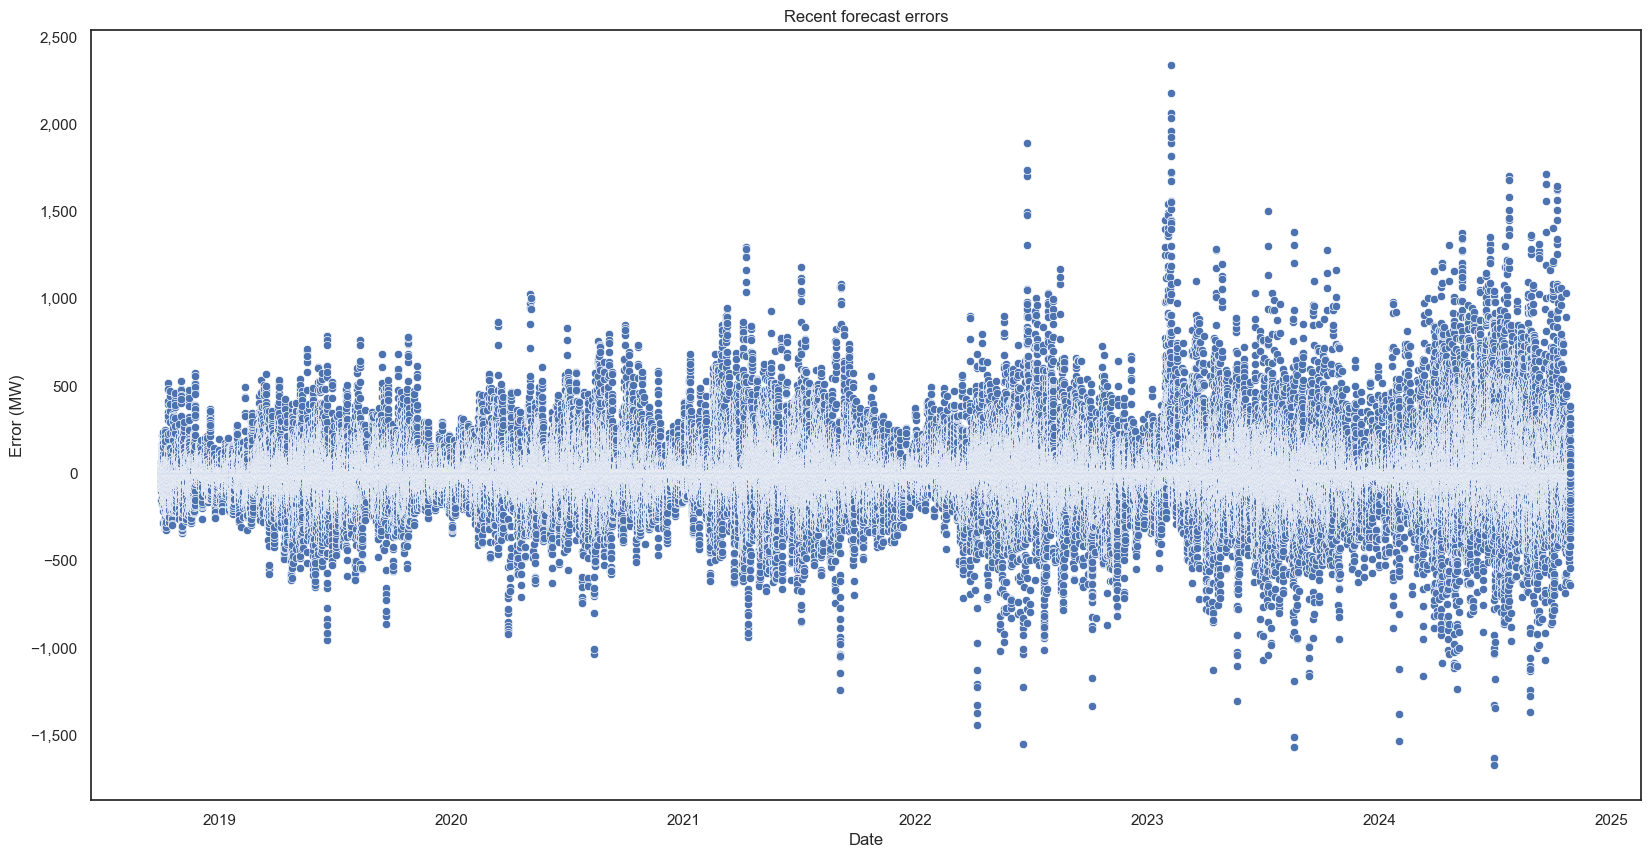

In [100]:
plt.figure(figsize=(20,10))
plt.title('Recent forecast errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error')
plt.ylabel('Error (MW)')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

# plt.figure(figsize=(20,10))
# plt.title('Recent forecast percentage errors')
# sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
# plt.ylabel('Error')
# plt.xlabel('Date')
# plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.legend(loc='upper right')
# plt.show()

In [8]:
def plot_forecast_errors_vs_measured(df, col_y, title):
    region_max = df_errs.groupby('region').measured.max().sort_values(ascending=False)
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for region in region_max.index.values:
        ax = sns.scatterplot(data=df_errs, x='datetime', y=col_y, label=region, size=1)
    plt.ylabel('Error (MW)')
    plt.xlabel('Date')
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
plot_forecast_errors_vs_measured(df_errs, 'forecast_recent_error', 'Most recent forecast errors')

In [ ]:
plot_forecast_errors_vs_measured(df_errs, 'forecast_week_error', 'Week forecast errors')

Recent forecast error statistics
Mean:		265
Median:		72
Std dev:	558
IQR:		229
MAD:		98


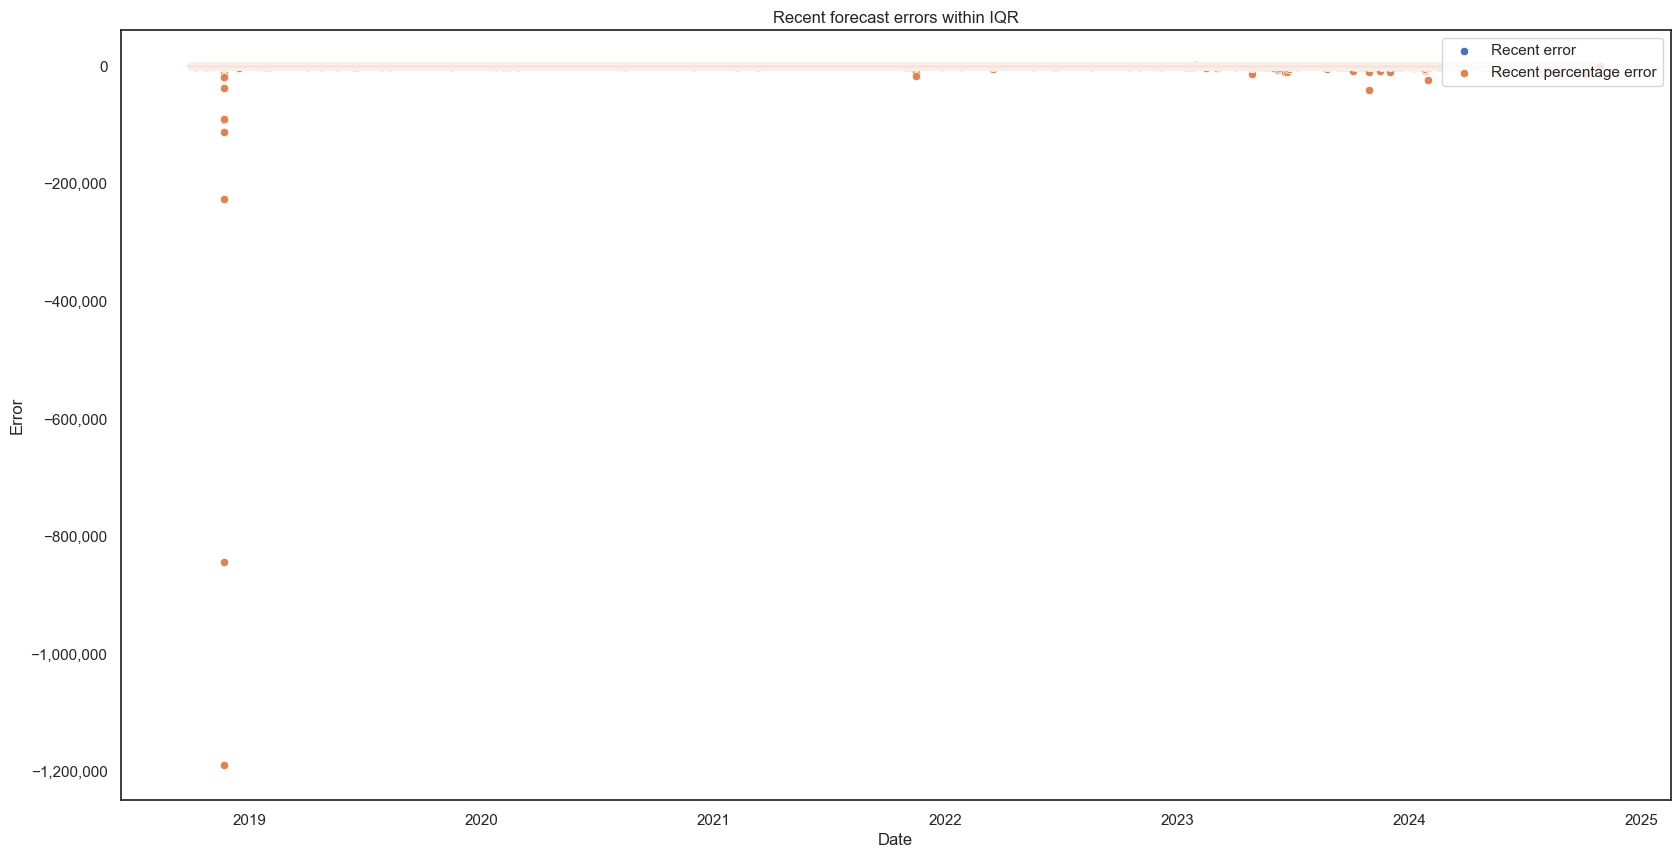

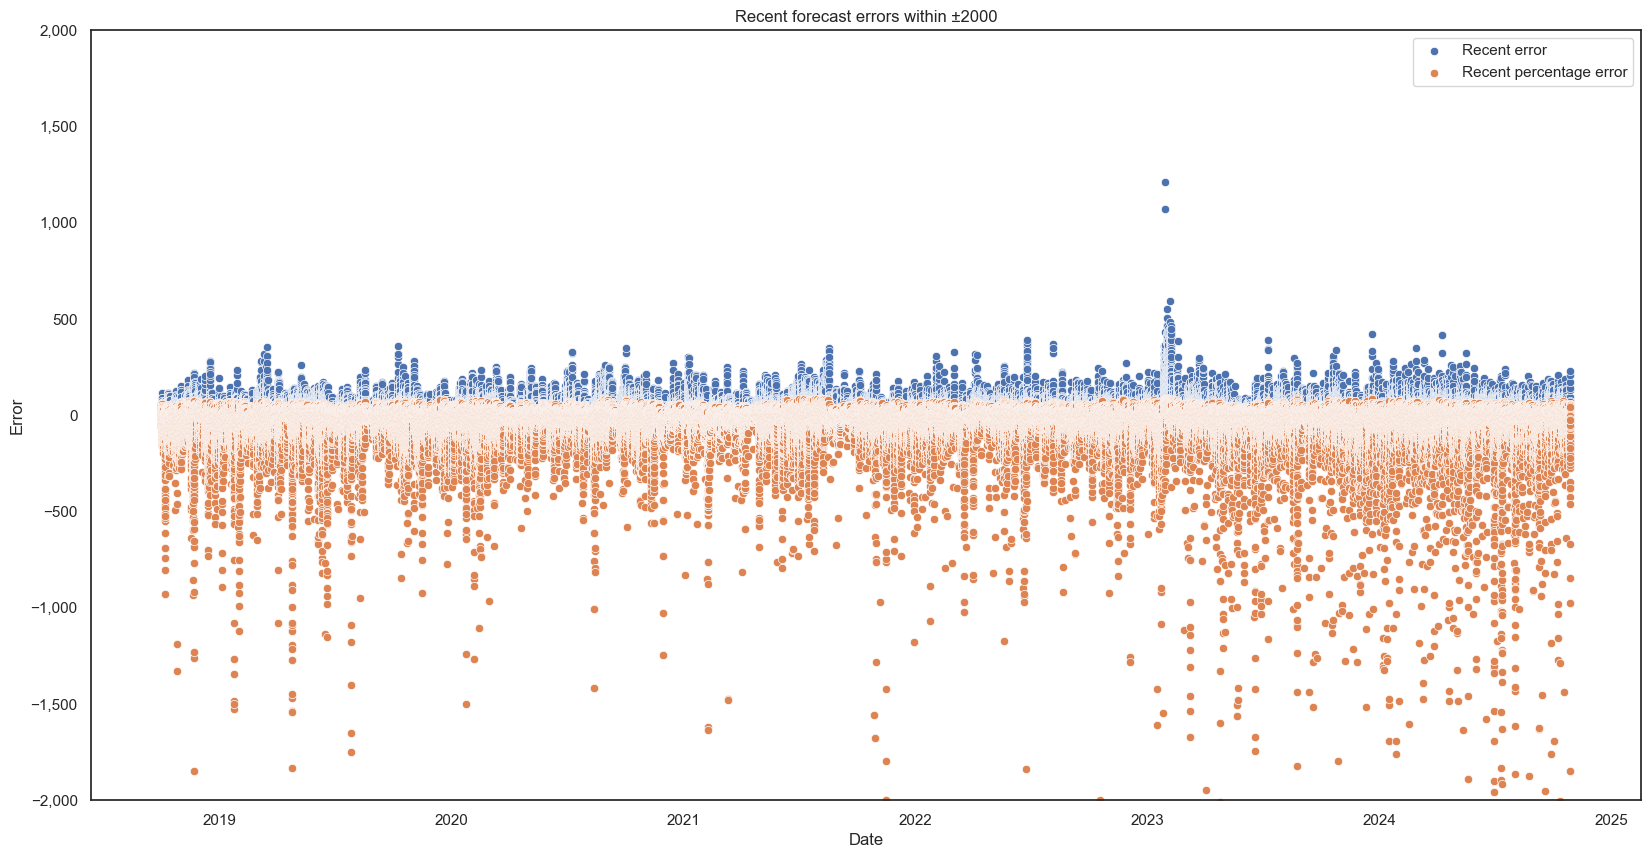

In [27]:
plt.figure(figsize=(20,10))
plt.title('Recent forecast errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error', label='Recent error')
plt.ylabel('Error (MW)')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Recent forecast percentage errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

q1 = df_errs.forecast_recent.quantile(0.25)
q3 = df_errs.forecast_recent.quantile(0.75)
df_errs_iqr = df_errs[(df_errs.forecast_recent >= q1) & (df_errs.forecast_recent <= q3)]

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors within IQR')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

# plt.figure(figsize=(20,10))
# plt.title('Recent forecast errors within ±2000')
# sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
# sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
# plt.ylabel('Error')
# plt.xlabel('Date')
# plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.legend(loc='upper right')
# plt.ylim(-2000,2000)
# plt.show()

In [31]:
def plot_forecast_errors_vs_measured_subplots(df, col_y, title):
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)
    regions = df.region.unique()
    rows, cols = 7, 2
    for i, region in enumerate(regions, 1):
        ax = plt.subplot(rows, cols, i)
        region_data = df[df.region == region]
        ax = sns.scatterplot(data=df_errs, x='datetime', y=col_y)
        ax.set_title(region)
        ax.set_ylabel('Error (MW)')
        ax.set_xlabel('Date')
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_aspect('equal', adjustable='box')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
plot_forecast_errors_vs_measured_subplots(df_errs, 'forecast_recent_error', 'Most recent forecast errors')

In [ ]:
plot_forecast_errors_vs_measured_subplots(df_errs, 'forecast_week_error', 'Week forecast errors')

# Modelling

## ARIMA

In [6]:
df_be_arima = df_be[['measured','forecast_week']].copy()

In [10]:
df_be_arima.measured['2022-01-01':'2023-12-31'].max() # Upper limit (e.g. for chart)

5709.982

### Single run

In [9]:
start = '2022-06-01'
back = 7
pred = 7
sm = 4
sa = 1
m = int(96/4/sa)
arima_file_title = f'belgium_{start}_{back}d_{pred}d_arima_sm{sm}sa{sa}'
arima_plot_title = f'Belgium, {back}d history, {pred}d forward (sm{sm}sa{sa})'

In [ ]:
model_all = auto_arima(df['2022-01-01':'2023-12-31'].measured, seasonal=True, m=96, stepwise=True, error_action="ignore", trace=True)

In [11]:
def run_model(df_in=df_be_arima, start='2023-06-01', back=7, pred=7, reduce='both', sa=4, sm=4, m=6, info=True, trace=True, stats=True, plot=True, plot_amount='all', plot_title='', save=False, file_title=''):
    start_date = pd.to_datetime(start).tz_localize('UTC')
    end_backward = start_date - pd.Timedelta(minutes=15)
    start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
    end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
    df_bwd = df_in[start_backward:end_backward]
    df_fwd = df_in[start_date:end_forward]
    df_all = df_in[start_backward:end_forward]

    def resample_h(df_in, h):
        r = f'{str(h)}h'
        s = int(96/4/int(h))
        return df_in.resample(r).mean(), s, r

    def resample_m(df_in, m):
        r = f'{str(60*m)}min'
        s = int(96/4/m)
        return df_in.resample(r).mean(), s, r

    def plot_pred(df_pred, df_f_in, plot_title, file_title):
        plt.figure(figsize=(20,10))
        sns.lineplot(df_f_in.measured, color = 'black', label='Actual')
        sns.lineplot(df_f_in.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
        sns.lineplot(df_pred[0], color = 'red', label='My forecast')
        sns.despine()
        plt.xlabel('')
        plt.ylabel('Generation (MW)')
        plt.legend(loc='upper left')
        plt.title(plot_title)
        plt.savefig(f'{file_title}', bbox_inches='tight', transparent=True)
        plt.show()

    _ = ''
    if reduce == 'sample':
        if sa > 0 and sa < 1:
            df_run, daily_samples, r = resample_m(df_bwd, sa)
            df_f, _, _ = resample_m(df_fwd, sa)
        else:
            df_run, daily_samples, r = resample_h(df_bwd, sa)
            df_f, _, _ = resample_h(df_fwd, sa)
    elif reduce == 'smooth':
        df_run = df_bwd.rolling(window=sm).mean().bfill()
        df_f = df_fwd
        daily_samples = 96
        r = f'{sm}x'
    elif reduce == 'both':
        df_run, daily_samples, r = resample_h(df_bwd.rolling(window=sm).mean().bfill(), sa)
        df_f, _, _ = resample_h(df_fwd.rolling(window=sm).mean().bfill(), sa)
    elif reduce == 'none':
        df_run = df_bwd
        df_f = df_fwd
        daily_samples = 96
        r = 'N/A'
    del _
    
    pred_periods = int(daily_samples*pred)

    if info:
        if pred != 0:
            if reduce == 'sample':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
            elif reduce == 'smooth':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
            elif reduce == 'both':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
            elif reduce == 'none':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
        else:
            if reduce == 'sample':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')
            elif reduce == 'smooth':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')
            elif reduce == 'both':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')
            elif reduce == 'none':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')

    if trace:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, error_action="ignore", trace=True)
    else:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, error_action="ignore")
    
    if pred != 0:
        df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
        df_auto_pred = df_auto_pred.clip(lower=0)
        # df_auto_pred.index = df_auto_pred.index + pd.Timedelta(hours=sa/2) # to shift samples

        if stats:
            stats = preds_vs_actual_stats_df(df_f.measured, df_auto_pred[0])
            print()
            display(stats)
            stats.to_csv(f'{file_title}.csv', index=False)

        if plot:
            if plot_amount == 'all':
                plot_pred(df_auto_pred, df_all, plot_title, file_title)
            elif plot_amount == 'future':
                plot_pred(df_auto_pred, df_f, plot_title, file_title)

    if save:
        with open(f'{file_title}.pkl', 'wb') as f:
            pickle.dump(model_auto, f)

    if pred != 0:
        return model_auto, df_auto_pred
    else:
        return model_auto

7 days of data, from 2022-05-25 to 2022-05-31
smoothed at 4x, then sampled at 1h, giving 168 values (24/day)
with a seasonal period of 24 (1 days)
with 168 predictons (7 days), until 2022-06-07

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=2167.527, Time=5.21 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2882.615, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=4.77 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=2982.995, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=2173.643, Time=2.42 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=2166.996, Time=2.88 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=2194.078, Time=0.78 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=2167.524, Time=10.66 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=inf, Time=20.88 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=2174.398, Time=3.76 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   :

Metric      Value
0             Mean (Actual)    1125.11
1          Mean (Predicted)    1110.59
2           Median (Actual)     527.98
3        Median (Predicted)     889.93
4             Mode (Actual)          0
5          Mode (Predicted)      20.47
6          Std Dev (Actual)    1330.44
7       Std Dev (Predicted)     722.11
8           Positive Errors     111.00
9           Negative Errors      57.00
10               Mean Error     -14.52
11                      MAE     574.45
12                      MSE  592932.82
13                     RMSE     770.02
14             Median Error     228.67
15                    MedAE     446.10
16               Mode Error   -2384.01
17            Std Dev Error     772.19
18                Min Error   -2384.01
19                Max Error    1454.08
20           Mean Error (%)    2604.27
21                     MAPE    2623.33
22                    SMAPE     100.43
23            Min Error (%)     -53.68
24            Max Error (%)  122933.05
25  Mean Bias Deviation (%)      -1.29
26                 R² Score       0.66
27  Correlation Coefficient       0.88
28                Theil's U       1.97

(ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 24),
       suppress_warnings=True),
                                     0
 2022-06-01 00:00:00+00:00   20.469119
 2022-06-01 01:00:00+00:00   59.214097
 2022-06-01 02:00:00+00:00  102.991455
 2022-06-01 03:00:00+00:00  144.279725
 2022-06-01 04:00:00+00:00  232.391176
 ...                               ...
 2022-06-07 19:00:00+00:00  695.071367
 2022-06-07 20:00:00+00:00  653.993495
 2022-06-07 21:00:00+00:00  652.802940
 2022-06-07 22:00:00+00:00  652.749619
 2022-06-07 23:00:00+00:00  652.705631
 
 [168 rows x 1 columns])

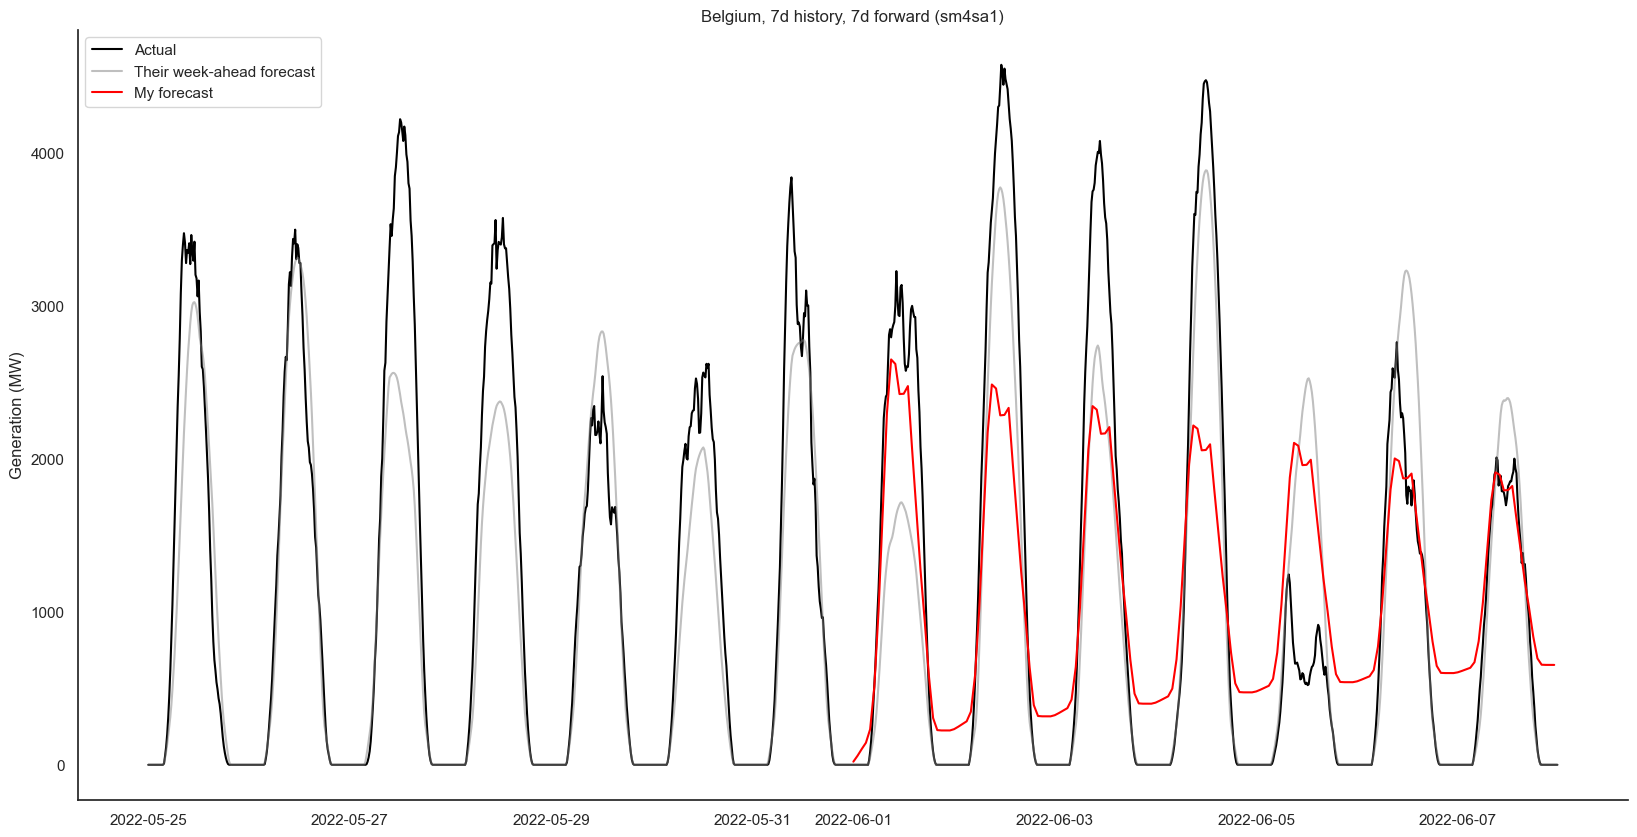

In [12]:
run_model(df_in=df_be_arima, start=start, back=back, pred=pred, reduce='both', sm=sm, sa=sa, m=m, info=True, trace=True, stats=True, plot=True, plot_amount='all', plot_title=arima_plot_title, save=True, file_title=arima_file_title)

### Sliding window

In [7]:
def slide_model(df_in=df_be_arima, start='2023-06-01', back=7, preds=(7,1), reduce='both', sa=4, sm=4, m=6, plot_title='', file_title=''):
    start_date = pd.to_datetime(start).tz_localize('UTC')
    end_backward = start_date - pd.Timedelta(minutes=15)
    start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
    df_bwd = df_in[start_backward:end_backward]

    def resample_h(df_in, h):
        r = f'{str(h)}h'
        s = int(96/4/int(h))
        return df_in.resample(r).mean(), s, r

    def resample_m(df_in, m):
        r = f'{str(60*m)}min'
        s = int(96/4/m)
        return df_in.resample(r).mean(), s, r

    _ = ''
    if reduce == 'sample':
        if sa > 0 and sa < 1:
            df_run, daily_samples, r = resample_m(df_bwd, sa)
        else:
            df_run, daily_samples, r = resample_h(df_bwd, sa)
    elif reduce == 'smooth':
        df_run = df_bwd.rolling(window=sm).mean().bfill()
        daily_samples = 96
        r = f'{sm}x'
    elif reduce == 'both':
        df_run, daily_samples, r = resample_h(df_bwd.rolling(window=sm).mean().bfill(), sa)
    elif reduce == 'none':
        df_run = df_bwd
        daily_samples = 96
        r = 'N/A'
    del _

    model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, error_action="ignore")
    
    for p in preds:
        pred_periods = int(daily_samples*p)
        file_title_p = file_title + f'-+{p}d'

        df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
        df_auto_pred = df_auto_pred.clip(lower=0)

        end_forward = start_date + pd.Timedelta(days=p) - pd.Timedelta(minutes=15)
        df_fwd = df_in[start_date:end_forward]
        df_all = df_in[start_backward:end_forward]

        _ = ''
        if reduce == 'sample':
            if sa > 0 and sa < 1:
                df_f, _, _ = resample_m(df_fwd, sa)
            else:
                df_f, _, _ = resample_h(df_fwd, sa)
        elif reduce == 'smooth':
            df_f = df_fwd
        elif reduce == 'both':
            df_f, _, _ = resample_h(df_fwd.rolling(window=sm).mean().bfill(), sa)
        elif reduce == 'none':
            df_f = df_fwd
        del _

        stats = preds_vs_actual_stats_df(df_f.measured, df_auto_pred[0])
        stats.to_csv(f'{file_title_p}.csv', index=False)

        plt.figure(figsize=(20,10))
        sns.lineplot(df_all.measured, color = 'black', label='Actual')
        sns.lineplot(df_all.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
        sns.lineplot(df_auto_pred[0], color = 'red', label='My forecast')
        sns.despine()
        plt.xlabel('')
        plt.ylabel('Generation (MW)')
        plt.ylim(0,6000)
        plt.legend(loc='upper left')
        plt.title(plot_title)
        plt.savefig(f'{file_title_p}', bbox_inches='tight', transparent=True)
        plt.close()

    with open(f'{file_title}.pkl', 'wb') as f:
        pickle.dump(model_auto, f)

In [ ]:
back = 7
preds = (7,1)
sm = 4
sa = 2
m = int(96/4/sa)
date_array = pd.date_range(start='2022-04-30', end='2022-12-31', freq='D').strftime('%Y-%m-%d').tolist()
print(len(date_array))

for date in tqdm(date_array, desc="Processing ARIMA models"):
    slide_file_title = f'belgium_{date}_{back}d_arima_sm{sm}sa{sa}'
    slide_plot_title = f'Belgium, {back}d history (sm{sm}sa{sa})'
    slide_model(df_in=df_be_arima, start=date, back=back, preds=preds, reduce='both', sm=sm, sa=sa, m=m, plot_title=slide_plot_title, file_title=slide_file_title)

### Combinations

#### Setup

In [30]:
combo_year = 2022
model_days = 7
days_to_predict = 1
directory = '/slide/'

#### Import models

In [ ]:
# by date

date_array = pd.date_range(start=f'{combo_year}-01-01', end=f'{combo_year}-12-31', freq='D').strftime('%Y-%m-%d').tolist()
models = []
for date in date_array:
    try:
        models.append(pickle.load(open(f'{directory}{combo_year}/{model_days}d/pkl/belgium_{date}_{model_days}d_arima_sm2sa2.pkl','rb')))
    except:
        print(f"belgium_{date}_{model_days}d_arima_sm2sa2.pkl doesn't exist")
len(models)

In [ ]:
# all .pkls in a single folder

models = []
pkl_directory = f'{directory}sm4sa2/'
for filename in os.listdir(pkl_directory):
    if filename.endswith('.pkl'):
        file_path = os.path.join(pkl_directory, filename)
        with open(file_path, 'rb') as f:
            models.append(pickle.load(f))
len(models)

In [ ]:
# all .pkls recusively

models = []
pkl_directory = f'{directory}{combo_year}'
for root, _, files in os.walk(pkl_directory):
    for filename in files:
        if filename.endswith('.pkl'):
            file_path = os.path.join(root, filename)
            with open(file_path, 'rb') as f:
                models.append(pickle.load(f))
len(models)

#### Predictions

In [ ]:
# generate

import_sa=2
n_per = int((96/4/import_sa)*days_to_predict)
preds = []
for model in models:
    preds.append(model.predict(n_periods=n_per))
print(len(preds)*len(preds[0]))

In [33]:
# combine and average

df_preds = pd.concat(preds, axis=1) # combines all the preds into a single df
average_preds_series = df_preds.mean(axis=1) # average the values for each date
average_preds_df = average_preds_series.to_frame(name='prediction') # convert to dataframe
# average_preds_df = average_preds_df.clip(lower=0) # remove negatives, if desired

#### Compare with actual

In [40]:
# prep actual data

average_actuals = df_be_arima[average_preds_df.iloc[0].name.strftime('%Y-%m-%d'):average_preds_df.iloc[-1].name.strftime('%Y-%m-%d')].copy()
average_actuals = average_actuals.resample('2h').mean()

In [ ]:
# plot

plt.figure(figsize=(20,8))
sns.lineplot(average_actuals.measured, color = 'black', label='Actual')
sns.lineplot(average_actuals.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
sns.lineplot(average_preds_df.prediction, color = 'red', label='My forecast')
sns.despine()
plt.xlabel('')
plt.ylabel('Generation (MW)')
plt.legend()
plt.title(f'Belgium {combo_year} combined prediction (ARIMA, {model_days}d history to {days_to_predict}d prediction, sm4 sa2)')
plt.savefig(f'{directory}belgium-{combo_year}-combined-prediction-arima-sm4sa2-{model_days}d-{days_to_predict}d', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
# stats

stats = preds_vs_actual_stats_df(average_preds_df.prediction, average_actuals.measured)
display(stats)
stats.to_csv(f'{directory}stats-{combo_year}-{model_days}d-{days_to_predict}d-sm4sa2.csv', index=False)

## Keras

In [ ]:
print("GPUs available:", len(list_physical_devices('GPU')))

GPUs available: 1


### Single feature

Created 175200 sequences of length 96
5475/5475 [==============================] - 75s 13ms/step


Metric       Value
0             Mean (Actual)      595.37
1          Mean (Predicted)      566.49
2           Median (Actual)        2.71
3        Median (Predicted)       14.97
4             Mode (Actual)           0
5          Mode (Predicted)           0
6          Std Dev (Actual)      995.42
7       Std Dev (Predicted)      951.86
8           Positive Errors    36540.00
9           Negative Errors    62410.00
10               Mean Error      -28.88
11                      MAE       55.53
12                      MSE    12488.66
13                     RMSE      111.75
14             Median Error           0
15                    MedAE        6.98
16               Mode Error           0
17            Std Dev Error      107.96
18                Min Error    -1459.16
19                Max Error     1285.72
20           Mean Error (%)     1199.74
21                     MAPE     1215.96
22                    SMAPE       45.52
23            Min Error (%)     -100.00
24            Max Error (%)  5243414.25
25  Mean Bias Deviation (%)       -4.85
26                 R² Score        0.99
27  Correlation Coefficient        0.99
28                Theil's U        1.37

100%|██████████| 17280/17280 [19:14<00:00, 14.97it/s]


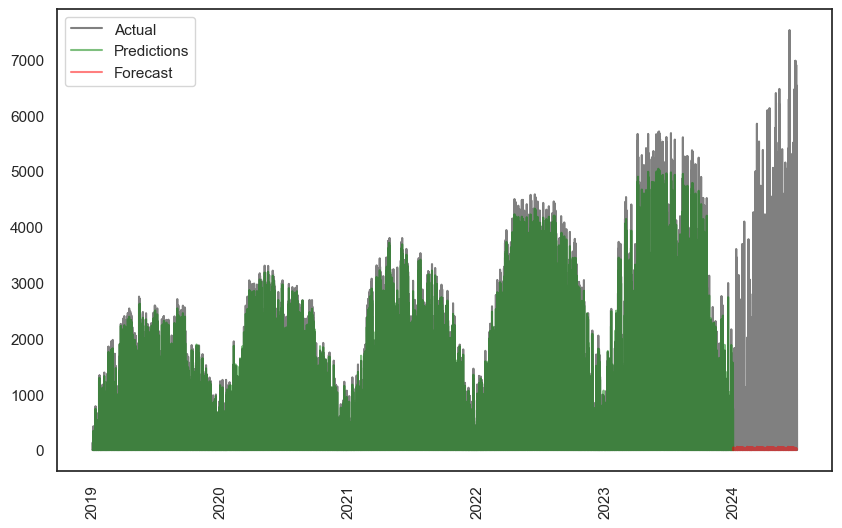

Metric       Value
0             Mean (Actual)      932.71
1          Mean (Predicted)        8.98
2           Median (Actual)       17.52
3        Median (Predicted)           0
4             Mode (Actual)           0
5          Mode (Predicted)           0
6          Std Dev (Actual)     1469.49
7       Std Dev (Predicted)       13.56
8           Positive Errors     4109.00
9           Negative Errors     9080.00
10               Mean Error     -923.73
11                      MAE      932.42
12                      MSE  3010324.04
13                     RMSE     1735.03
14             Median Error      -11.11
15                    MedAE       44.18
16               Mode Error           0
17            Std Dev Error     1468.73
18                Min Error    -7475.42
19                Max Error       57.98
20           Mean Error (%)      990.25
21                     MAPE     1093.08
22                    SMAPE      193.97
23            Min Error (%)     -100.00
24            Max Error (%)  1497537.18
25  Mean Bias Deviation (%)      -99.04
26                 R² Score       -0.39
27  Correlation Coefficient        0.06
28                Theil's U       14.18

In [ ]:
# user inputs

date_start = '2019-01-01' # '2022-06-01' '2022-02-26'
date_train_end = '2023-12-31' # '2022-06-21' '2022-03-04'
date_predict_start = '2024-01-01' # '2022-06-22' '2022-03-05'
date_end = '2024-06-30' # '2022-06-30' '2022-03-11' 
days_to_predict = 180
seq_length = 96
num_features = 1

# get the data

df_tf = df_be[['measured']][date_back:date_end].copy()
df_tf_train = df_be[['measured']][date_back:date_train_end].copy()
df_tf_predict = df_be[['measured']][date_predict_start:date_end].copy()

# scale the data

scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_train_scaled = scaler.fit_transform(df_tf_train)

# create sequnces

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    print(f'Created {len(X)} sequences of length {seq_length}')
    return np.array(X), np.array(y)

X, y = create_sequences(df_tf_train_scaled, seq_length)

# define the model

model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh'),
    Dense(1)
])

# split into train and validation data

train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# fit the model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

# test the model through predictions

predictions = model.predict(X)
predictions = np.maximum(predictions, 0)
predictions = scaler.inverse_transform(predictions)

display(preds_vs_actual_stats_df(df_tf_train[seq_length:].reset_index().measured, pd.Series(predictions.reshape(-1))))

# future forecasts

forecast_period = seq_length * days_to_predict
forecast = []
last_sequence = X[-1].flatten()

for _ in tqdm(range(forecast_period)):
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    next_prediction = np.float32(np.maximum(model.predict(current_sequence, verbose=0)[0][0],0))
    forecast.append(next_prediction)
    last_sequence = np.append(last_sequence[1:], next_prediction)

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# plot results

plt.figure(figsize=(10, 6))
plt.plot(df_tf.index, df_tf.measured, label='Actual', color='gray')
plt.plot(df_tf_train.index[seq_length:], predictions, label='Predictions', color='green', alpha=0.5)
plt.plot(df_tf_predict.index[:len(forecast)], forecast, label='Forecast', color='red', alpha=0.5)
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

# results statistics

display(preds_vs_actual_stats_df(df_tf_predict[:len(forecast)].reset_index().measured, pd.Series(forecast.reshape(-1))))

### Multiple features

  0%|          | 0/672 [00:00<?, ?it/s]

100%|██████████| 672/672 [01:48<00:00,  6.21it/s]


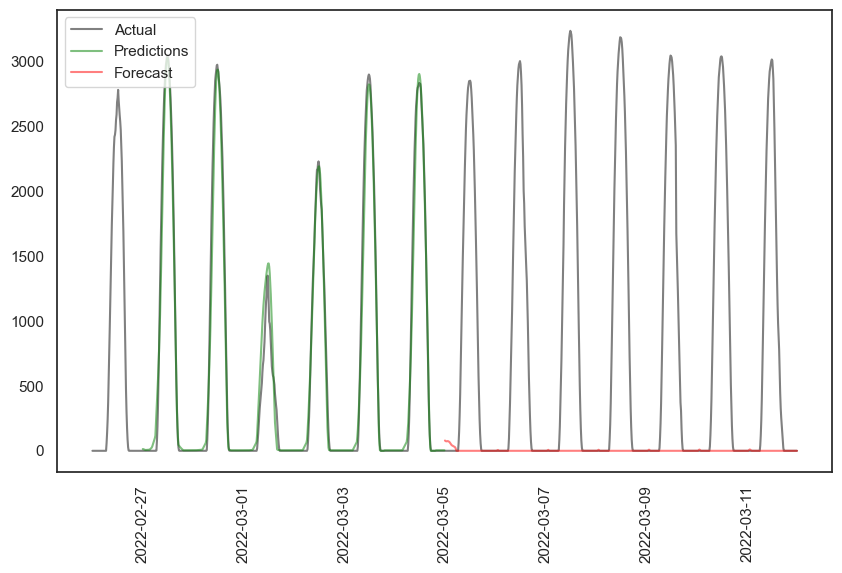

Metric       Value
0             Mean (Actual)      804.01
1          Mean (Predicted)        1.94
2           Median (Actual)           0
3        Median (Predicted)           0
4             Mode (Actual)           0
5          Mode (Predicted)           0
6          Std Dev (Actual)     1126.12
7       Std Dev (Predicted)       10.24
8           Positive Errors       48.00
9           Negative Errors      328.00
10               Mean Error     -802.07
11                      MAE      805.95
12                      MSE  1912805.37
13                     RMSE     1383.04
14             Median Error           0
15                    MedAE        9.82
16               Mode Error           0
17            Std Dev Error     1127.55
18                Min Error    -3233.16
19                Max Error       79.06
20           Mean Error (%)      -48.81
21                     MAPE       48.81
22                    SMAPE      200.00
23            Min Error (%)     -100.00
24            Max Error (%)           0
25  Mean Bias Deviation (%)      -99.76
26                 R² Score       -0.51
27  Correlation Coefficient       -0.14
28                Theil's U       12.92

In [ ]:
# user inputs

date_start = '2019-01-01' # '2022-06-01' '2022-02-26'
date_train_end = '2023-12-31' # '2022-06-21' '2022-03-04'
date_predict_start = '2024-01-01' # '2022-06-22' '2022-03-05'
date_end = '2024-06-30' # '2022-06-30' '2022-03-11' 
days_to_predict = 180
seq_length = 96

# prepare the data and features

df_tf = df_be[['measured']][date_start:date_end].copy()

df_tf['day_of_year'] = df_tf.index.dayofyear
df_tf['hour'] = df_tf.index.hour + df_tf.index.minute / 60
df_tf['day_of_year_sin'] = np.sin(2 * np.pi * df_tf['day_of_year'] / 365)
df_tf['day_of_year_cos'] = np.cos(2 * np.pi * df_tf['day_of_year'] / 365)
df_tf['hour_sin'] = np.sin(2 * np.pi * df_tf['hour'] / 24)
df_tf['hour_cos'] = np.cos(2 * np.pi * df_tf['hour'] / 24)

df_tf = df_tf.drop(['day_of_year','hour'], axis=1)

df_tf_train = df_tf[date_start:date_train_end].copy()
df_tf_predict = df_tf[date_predict_start:date_end].copy()

# scale the data

scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_train_scaled = scaler.fit_transform(df_tf_train)

# create sequences

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    print(f'Created {len(X)} sequences of length {seq_length}')
    return np.array(X), np.array(y)

X, y = create_sequences(df_tf_train_scaled, seq_length)

# define the model

num_features = X.shape[2]

model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh'),
    Dense(1)
])

# split into train and validation data

train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# fit the model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

# test the model through predictions

predictions = model.predict(X)
predictions = np.maximum(predictions, 0)
predictions_with_dummy_columns = np.hstack([predictions, np.zeros((predictions.shape[0], df_tf_train.shape[1] - 1))])
predictions_inverse = scaler.inverse_transform(predictions_with_dummy_columns)
predictions = predictions_inverse[:, 0]

display(preds_vs_actual_stats_df(df_tf_train[seq_length:].reset_index().measured, pd.Series(predictions.reshape(-1))))

# future forecasts

forecast_period = seq_length * days_to_predict
forecast = []
last_sequence = X[-1]

for _ in tqdm(range(forecast_period)):
    current_sequence = last_sequence.reshape(1, seq_length, num_features)
    next_prediction = np.float32(np.maximum(model.predict(current_sequence, verbose=0)[0][0],0))
    forecast.append(next_prediction)

    next_hour = (df_tf.index[-1] + pd.Timedelta(minutes=15) * len(forecast)).hour + (df_tf.index[-1].minute / 60)
    next_day_of_year = (df_tf.index[-1] + pd.Timedelta(minutes=15) * len(forecast)).dayofyear
    day_sin = np.sin(2 * np.pi * next_day_of_year / 365)
    day_cos = np.cos(2 * np.pi * next_day_of_year / 365)
    hour_sin = np.sin(2 * np.pi * next_hour / 24)
    hour_cos = np.cos(2 * np.pi * next_hour / 24)
    last_sequence = np.append(last_sequence[1:], [[next_prediction, day_sin, day_cos, hour_sin, hour_cos]], axis=0)

forecast = scaler.inverse_transform(np.concatenate([np.array(forecast).reshape(-1, 1), np.zeros((len(forecast), num_features-1))], axis=1))[:, 0]

# plot results

plt.figure(figsize=(10, 6))
plt.plot(df_tf.index, df_tf.measured, label='Actual', color='gray')
plt.plot(df_tf_train.index[seq_length:], predictions, label='Predictions', color='green', alpha=0.5)
plt.plot(df_tf_predict.index[:len(forecast)], forecast, label='Forecast', color='red', alpha=0.5)
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

# results statistics

display(preds_vs_actual_stats_df(df_tf_predict[:len(forecast)].reset_index().measured, pd.Series(forecast.reshape(-1))))

### Comparing of models

In [ ]:
# same as multiple inputs, rebuild data as required

date_start = '2019-01-01' # '2022-06-01' '2022-02-26'
date_train_end = '2023-12-31' # '2022-06-21' '2022-03-04'
date_predict_start = '2024-01-01' # '2022-06-22' '2022-03-05'
date_end = '2024-06-30' # '2022-06-30' '2022-03-11' 
seq_length = 96
df_tf = df_be[['measured']][date_start:date_end].copy()
df_tf['day_of_year'] = df_tf.index.dayofyear
df_tf['hour'] = df_tf.index.hour + df_tf.index.minute / 60  # Capture partial hours if needed
df_tf['day_of_year_sin'] = np.sin(2 * np.pi * df_tf['day_of_year'] / 365)
df_tf['day_of_year_cos'] = np.cos(2 * np.pi * df_tf['day_of_year'] / 365)
df_tf['hour_sin'] = np.sin(2 * np.pi * df_tf['hour'] / 24)
df_tf['hour_cos'] = np.cos(2 * np.pi * df_tf['hour'] / 24)
df_tf = df_tf.drop(['day_of_year','hour'], axis=1)
df_tf_train = df_tf[date_start:date_train_end].copy()
df_tf_predict = df_tf[date_predict_start:date_end].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_train_scaled = scaler.fit_transform(df_tf_train)
X, y = create_sequences(df_tf_train_scaled, seq_length) # same function as multiple inputs
num_features = X.shape[2]

In [ ]:
models = {
    1: Sequential([
        LSTM(50, activation='tanh', input_shape=(seq_length, num_features)),
        Dense(1)
    ]),
    2: Sequential([
        LSTM(100, activation='tanh', input_shape=(seq_length, num_features)),
        Dense(1)
    ]),
    3: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    4: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    5: Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(100, activation='tanh', return_sequences=True),
        LSTM(100, activation='tanh'),
        Dense(1)
    ]),
    6: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    7: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    8: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(100, activation='tanh'),
        Dense(1)
    ]),
    9: Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    10: Sequential([
        LSTM(50, activation='tanh', input_shape=(seq_length, num_features), dropout=0.2),
        Dense(1)
    ]),
    11: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features), dropout=0.2),
        LSTM(50, activation='tanh', dropout=0.2),
        Dense(1)
    ]),
    12: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features), dropout=0.2),
        LSTM(50, activation='tanh', return_sequences=True, dropout=0.2),
        LSTM(50, activation='tanh', dropout=0.2),
        Dense(1)
    ]),
    13: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        BatchNormalization(),
        LSTM(50, activation='tanh'),
        BatchNormalization(),
        Dense(1)
    ]),
    14: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        BatchNormalization(),
        LSTM(50, activation='tanh', return_sequences=True),
        BatchNormalization(),
        LSTM(50, activation='tanh'),
        BatchNormalization(),
        Dense(1)
    ]),
    15: Sequential([
        LSTM(50, activation='tanh', input_shape=(seq_length, num_features)),
        Dense(10, activation='relu'),
        Dense(1)
    ]),
    16: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(100, activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1)
    ]),
    17: Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1)
    ]),
    18: Sequential([
        LSTM(200, activation='tanh', input_shape=(seq_length, num_features)),
        Dense(1)
    ]),
    19: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(200, activation='tanh'),
        Dense(1)
    ]),
    20: Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=(seq_length, num_features)),
        Dense(1)
    ]),
    21: Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    22: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    23: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(64, 3, activation='relu'),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    24: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(128, 3, activation='relu'),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    25: Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(100, activation='tanh'),
        Dropout(0.3),
        Dense(1)
    ]),
    26: Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    27: Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(64, 3, activation='relu'),
        Dropout(0.3),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    28: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(32, 3, activation='relu'),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(1)
    ]),
    29: Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(100, activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1)
    ]),
    30: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        Conv1D(64, 3, activation='relu'),
        Dense(1)
    ]),
    31: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    32: Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    33: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(64, 3, activation='relu'),
        LSTM(50, activation='tanh'),
        Dropout(0.3),
        Dense(1)
    ]),
    34: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(64, 3, activation='relu'),
        LSTM(50, activation='tanh'),
        Dense(10, activation='relu'),
        Dense(1)
    ]),
    35: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(128, 3, activation='relu'),
        Dropout(0.2),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    36: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(100, activation='tanh', return_sequences=True),
        Dropout(0.3),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    37: Sequential([
        LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(64, 3, activation='relu'),
        Dropout(0.3),
        LSTM(100, activation='tanh'),
        Dense(1)
    ]),
    38: Sequential([
        LSTM(50, activation='tanh', return_sequences=True, input_shape=(seq_length, num_features)),
        Conv1D(64, 3, activation='relu'),
        LSTM(50, activation='tanh'),
        Dropout(0.5),
        Dense(1)
    ]),
    39: Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=(seq_length, num_features)),
        Dense(1)
    ]),
    40: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    41: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    42: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    43: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    44: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    45: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    46: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ]),
    47: Sequential([
        Conv1D(128, 3, activation='relu', input_shape=(seq_length, num_features)),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh', return_sequences=True),
        LSTM(50, activation='tanh'),
        Dense(1)
    ])
}

In [ ]:
# split into train and validation data

train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# fit the models

early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
scores = []

for model_num, model in models.items():
    print(f'Fitting model {model_num} of {len(models)}')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X, y, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)
    scores.append({
        'model': model_num,
        'loss': history.history['loss'][-1], 
        'val_loss': history.history['val_loss'][-1],
        'delta': abs(history.history['loss'][-1] - history.history['val_loss'][-1])
    })

# display scores

scores_df = pd.DataFrame(scores).sort_values('val_loss')
display(scores_df.set_index('model'))

## Prophet

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

raw_data = pd.read_csv('ods032-api.csv')
df = raw_data.copy()
df_p = df.copy()
df_p = df_p[df_p.region == 'Belgium']
df_p.set_index("datetime", inplace=True)
df_p = df_p.sort_index()
df_p = df_p['2022-06-01':'2022-06-31']
df_p.reset_index(inplace=True)
df_p['datetime'] = pd.to_datetime(df_p.datetime, utc=True)
df_p['datetime'] = df_p['datetime'].dt.tz_localize(None)
df_p = df_p.rename(columns={'datetime':'ds', 'measured':'y'})
df_p = df_p.ffill().bfill()
df_p = df_p[['ds','y']]
df_p['floor'] = 0

samples_per_day = 96
days_to_predict = 180

In [ ]:
m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(df_p)

future = m.make_future_dataframe(periods=samples_per_day*days_to_predict, freq="15min")
future['floor'] = 0

forecast = m.predict(future)

In [ ]:
m.plot(forecast)

In [ ]:
m.plot_components(forecast)

In [ ]:
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

# Import and analyse statistics CSVs

In [ ]:
# single folder

directory = '/csvs'
csv_dfs = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        csv_df = pd.read_csv(filepath)
        csv_df.set_index('Metric', inplace=True)
        csv_df.columns = [filename.replace('belgium_','').replace('_arima_sm2sa2-+','').replace('.csv','')]
        csv_dfs.append(csv_df)
csv_dfs_combined = pd.concat(csv_dfs, axis=1)
csv_dfs_combined_T = csv_dfs_combined.T
csv_dfs_combined_T.describe()

In [ ]:
# resursively

directory = '/csvs'
csv_dfs = []
for root, _, files in os.walk(directory):
    for filename in files:
        if filename.endswith('.csv'):
            filepath = os.path.join(root, filename)
            csv_df = pd.read_csv(filepath)
            csv_df.set_index('Metric', inplace=True)
            csv_df.columns = [filename.replace('belgium_','').replace('_arima_sm2sa2-+','').replace('.csv','')]
            csv_dfs.append(csv_df)
csv_dfs_combined = pd.concat(csv_dfs, axis=1)
csv_dfs_combined_T = csv_dfs_combined.T
csv_dfs_combined_T.describe()

In [ ]:
csv_dfs_combined_T[csv_dfs_combined_T['R² Score'] == 0.99]

In [ ]:
csv_dfs_combined_T[csv_dfs_combined_T['MAPE'] < 15]